# Distance-of-Distances Measures: Patient Comparison

This notebook extends the permutation-robust comparison by evaluating **all distance-of-distances measures** available in the project. For every patient, EEG band, and experimental phase we:

1. Build ultrametric, linkage, and condensed distance structures.
2. Compute the following measures across every phase pair:
   - Ultrametric Matrix Distance
   - Ultrametric Scaled Distance (log scaling)
   - Ultrametric Rank Correlation (converted to a distance)
   - Ultrametric Quantile RMSE (log scaling)
   - Ultrametric Distance (Permutation Robust)
   - Robinson–Foulds Distance
   - Cophenetic Correlation (distance form)
   - Baker's Gamma (distance form)
   - Fowlkes–Mallows Index (distance form)
3. Plot patient-wise heatmaps per band for each measure.


In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

from lrgsglib import *
move_to_rootf(pathname='lrg_eegfc')

from lrg_eegfc.notebook import *
from lrg_eegfc.utils.datamanag.loaders import load_data_dict
from lrg_eegfc.utils.corrmat.structures import compute_structures_for_patient

from lrgsglib.utils.basic.linalg import (
    ultrametric_matrix_distance,
    ultrametric_scaled_distance,
    ultrametric_rank_correlation,
    ultrametric_quantile_rmse,
    ultrametric_distance_permutation_robust,
    tree_robinson_foulds_distance,
    tree_cophenetic_correlation,
    tree_baker_gamma,
    tree_fowlkes_mallows_index,
)

path_figs = Path('data') / 'figures' / 'DSTCMP_all_distance_measures'
path_figs.mkdir(parents=True, exist_ok=True)

phase_labels = list(PHASE_LABELS)
bands = list(BRAIN_BANDS_NAMES)
patients = list(PATIENTS_LIST)
correlation_protocol = dict(filter_type='abs', spectral_cleaning=False)

print(f'Patients: {patients}')
print(f'Phases: {phase_labels}')
print(f'Bands: {bands}')


Current working directory: /home/opisthofulax/Documents/research+/brain_network/lrg_eegfc
Patients: ['Pat_03', 'Pat_02']
Phases: ['rsPre', 'taskLearn', 'taskTest', 'rsPost']
Bands: ['delta', 'theta', 'alpha', 'beta', 'low_gamma', 'high_gamma']


In [2]:
data_dict, int_label_map = load_data_dict()
pin_labels_by_pat = {pat: int_label_map[pat]['label'] for pat in patients}
print('✓ Data loaded')


✓ Data loaded


In [3]:
ultra_by_pat = {}
linkage_by_pat = {}
condensed_by_pat = {}

for pat in patients:
    print(f'Computing ultrametric structures for {pat} ...')
    U, Z, D = compute_structures_for_patient(
        data_dict,
        pat,
        int_label_map,
        bands=bands,
        phases=phase_labels,
        correlation_protocol=correlation_protocol,
    )
    ultra_by_pat[pat] = U
    linkage_by_pat[pat] = Z
    condensed_by_pat[pat] = D

print('✓ Ultrametric structures computed for all patients')


Computing ultrametric structures for Pat_03 ...


/home/opisthofulax/Documents/research+/brain_network/lrg_eegfc/lrgsglib/src/lrgsglib/utils/basic/signals.py:58: RuntimeWarning: Very narrow filter bandwidth (0.0068 of Nyquist). Consider reducing filter order or increasing bandwidth.
  warnings.warn(
/home/opisthofulax/Documents/research+/brain_network/lrg_eegfc/lrgsglib/src/lrgsglib/utils/basic/signals.py:58: RuntimeWarning: Very narrow filter bandwidth (0.0078 of Nyquist). Consider reducing filter order or increasing bandwidth.
  warnings.warn(
/home/opisthofulax/Documents/research+/brain_network/lrg_eegfc/lrgsglib/src/lrgsglib/utils/basic/signals.py:58: RuntimeWarning: Very narrow filter bandwidth (0.0078 of Nyquist). Consider reducing filter order or increasing bandwidth.
  warnings.warn(
/home/opisthofulax/Documents/research+/brain_network/lrg_eegfc/lrgsglib/src/lrgsglib/utils/basic/signals.py:58: RuntimeWarning: Very narrow filter bandwidth (0.0098 of Nyquist). Consider reducing filter order or increasing bandwidth.
  warnings.wa

Computing ultrametric structures for Pat_02 ...


/home/opisthofulax/Documents/research+/brain_network/lrg_eegfc/lrgsglib/src/lrgsglib/utils/basic/signals.py:58: RuntimeWarning: Very narrow filter bandwidth (0.0034 of Nyquist). Consider reducing filter order or increasing bandwidth.
  warnings.warn(
/home/opisthofulax/Documents/research+/brain_network/lrg_eegfc/lrgsglib/src/lrgsglib/utils/basic/signals.py:58: RuntimeWarning: Very narrow filter bandwidth (0.0039 of Nyquist). Consider reducing filter order or increasing bandwidth.
  warnings.warn(
/home/opisthofulax/Documents/research+/brain_network/lrg_eegfc/lrgsglib/src/lrgsglib/utils/basic/signals.py:58: RuntimeWarning: Very narrow filter bandwidth (0.0039 of Nyquist). Consider reducing filter order or increasing bandwidth.
  warnings.warn(
/home/opisthofulax/Documents/research+/brain_network/lrg_eegfc/lrgsglib/src/lrgsglib/utils/basic/signals.py:58: RuntimeWarning: Very narrow filter bandwidth (0.0049 of Nyquist). Consider reducing filter order or increasing bandwidth.
  warnings.wa

✓ Ultrametric structures computed for all patients


In [4]:
n_phases = len(phase_labels)

def compute_phase_distance_matrix(pat: str, band: str, diag_value: float, compute_fn):
    dm = np.full((n_phases, n_phases), np.nan, dtype=float)
    for i, pi in enumerate(phase_labels):
        for j, pj in enumerate(phase_labels):
            if i == j:
                dm[i, j] = diag_value
                continue
            try:
                value = compute_fn(pi, pj)
            except Exception as exc:
                print(f'[WARN] {pat} {band} {pi}->{pj}: {exc}')
                value = np.nan
            if value is None:
                dm[i, j] = np.nan
            else:
                val = float(value)
                dm[i, j] = val if np.isfinite(val) else np.nan
    return dm

def plot_measure_across_patients(measure_key: str, measure_label: str, cbar_label: str):
    outdir = path_figs / measure_key
    outdir.mkdir(parents=True, exist_ok=True)

    for band in bands:
        vmax = 0.0
        for pat in patients:
            M = measure_results[measure_key][band].get(pat)
            if M is not None and np.isfinite(M).any():
                vmax = max(vmax, np.nanmax(M))
        if vmax == 0.0:
            print(f'[SKIP] No finite values for {measure_label} / {band}')
            continue

        fig, axes = plt.subplots(1, len(patients), figsize=(4 * len(patients) + 2, 4), constrained_layout=True)
        if len(patients) == 1:
            axes = [axes]

        cmap = plt.cm.viridis.copy()
        cmap.set_bad(color='lightgray')

        for ax, pat in zip(axes, patients):
            M = measure_results[measure_key][band][pat]
            im = ax.imshow(M, vmin=0.0, vmax=vmax, cmap=cmap, aspect='equal')
            ax.set_title(pat)
            ax.set_xticks(range(n_phases))
            ax.set_yticks(range(n_phases))
            ax.set_xticklabels(phase_labels, rotation=45, ha='right')
            ax.set_yticklabels(phase_labels)
            for spine in ax.spines.values():
                spine.set_visible(False)

        cbar = fig.colorbar(im, ax=axes, shrink=0.85)
        cbar.set_label(cbar_label)
        fig.suptitle(f'{measure_label} — {band} band', fontsize=14)

        outfile = outdir / f'{band}.png'
        fig.savefig(outfile, dpi=200, bbox_inches='tight')
        plt.show()
        print(f'Saved: {outfile}')


measure_results = {}
plot_specs = {}


In [5]:
# Ultrametric-based measures
measure_key = 'ultrametric_matrix_distance'
measure_results[measure_key] = {band: {} for band in bands}
plot_specs[measure_key] = dict(
    label='Ultrametric Matrix Distance',
    cbar='Ultrametric matrix distance (euclidean)',
)
for band in bands:
    for pat in patients:
        U_band = ultra_by_pat[pat][band]

        def compute_fn(pi, pj, U_band=U_band):
            U1 = U_band.get(pi)
            U2 = U_band.get(pj)
            if U1 is None or U2 is None or U1.shape != U2.shape:
                return np.nan
            return ultrametric_matrix_distance(U1, U2, metric='euclidean')

        measure_results[measure_key][band][pat] = compute_phase_distance_matrix(pat, band, 0.0, compute_fn)
    print(f'Band {band}: ✓ Ultrametric Matrix Distance computed')
print('✓ Ultrametric Matrix Distance complete')

measure_key = 'ultrametric_scaled_distance_log'
measure_results[measure_key] = {band: {} for band in bands}
plot_specs[measure_key] = dict(
    label='Ultrametric Scaled Distance (log)',
    cbar='Ultrametric scaled distance (log)',
)
for band in bands:
    for pat in patients:
        U_band = ultra_by_pat[pat][band]

        def compute_fn(pi, pj, U_band=U_band):
            U1 = U_band.get(pi)
            U2 = U_band.get(pj)
            if U1 is None or U2 is None or U1.shape != U2.shape:
                return np.nan
            return ultrametric_scaled_distance(U1, U2, metric='euclidean', scale='log', normalize=True)

        measure_results[measure_key][band][pat] = compute_phase_distance_matrix(pat, band, 0.0, compute_fn)
    print(f'Band {band}: ✓ Ultrametric Scaled Distance computed')
print('✓ Ultrametric Scaled Distance complete')

measure_key = 'ultrametric_rank_correlation_spearman'
measure_results[measure_key] = {band: {} for band in bands}
plot_specs[measure_key] = dict(
    label='Ultrametric Rank Correlation (1 - spearman)',
    cbar='Distance (1 - spearman correlation)',
)
for band in bands:
    for pat in patients:
        U_band = ultra_by_pat[pat][band]

        def compute_fn(pi, pj, U_band=U_band):
            U1 = U_band.get(pi)
            U2 = U_band.get(pj)
            if U1 is None or U2 is None or U1.shape != U2.shape:
                return np.nan
            corr = ultrametric_rank_correlation(U1, U2, method='spearman')
            return 1.0 - corr if corr is not None else np.nan

        measure_results[measure_key][band][pat] = compute_phase_distance_matrix(pat, band, 0.0, compute_fn)
    print(f'Band {band}: ✓ Ultrametric Rank Correlation computed')
print('✓ Ultrametric Rank Correlation complete')

measure_key = 'ultrametric_quantile_rmse_log'
measure_results[measure_key] = {band: {} for band in bands}
plot_specs[measure_key] = dict(
    label='Ultrametric Quantile RMSE (log)',
    cbar='Ultrametric quantile RMSE (log scale)',
)
for band in bands:
    for pat in patients:
        U_band = ultra_by_pat[pat][band]

        def compute_fn(pi, pj, U_band=U_band):
            U1 = U_band.get(pi)
            U2 = U_band.get(pj)
            if U1 is None or U2 is None or U1.shape != U2.shape:
                return np.nan
            return ultrametric_quantile_rmse(U1, U2, scale='log')

        measure_results[measure_key][band][pat] = compute_phase_distance_matrix(pat, band, 0.0, compute_fn)
    print(f'Band {band}: ✓ Ultrametric Quantile RMSE computed')
print('✓ Ultrametric Quantile RMSE complete')


Band delta: ✓ Ultrametric Matrix Distance computed
Band theta: ✓ Ultrametric Matrix Distance computed
Band alpha: ✓ Ultrametric Matrix Distance computed
Band beta: ✓ Ultrametric Matrix Distance computed
Band low_gamma: ✓ Ultrametric Matrix Distance computed
Band high_gamma: ✓ Ultrametric Matrix Distance computed
✓ Ultrametric Matrix Distance complete
Band delta: ✓ Ultrametric Scaled Distance computed
Band theta: ✓ Ultrametric Scaled Distance computed
Band alpha: ✓ Ultrametric Scaled Distance computed
Band beta: ✓ Ultrametric Scaled Distance computed
Band low_gamma: ✓ Ultrametric Scaled Distance computed
Band high_gamma: ✓ Ultrametric Scaled Distance computed
✓ Ultrametric Scaled Distance complete
Band delta: ✓ Ultrametric Rank Correlation computed
Band theta: ✓ Ultrametric Rank Correlation computed
Band alpha: ✓ Ultrametric Rank Correlation computed
Band beta: ✓ Ultrametric Rank Correlation computed
Band low_gamma: ✓ Ultrametric Rank Correlation computed
Band alpha: ✓ Ultrametric Rank 

In [6]:
# Permutation-robust ultrametric distance
measure_key = 'ultrametric_distance_permutation_robust'
measure_results[measure_key] = {band: {} for band in bands}
plot_specs[measure_key] = dict(
    label='Ultrametric Distance (Permutation Robust)',
    cbar='Permutation-robust distance (euclidean)',
)
for band in bands:
    for pat in patients:
        Z_band = linkage_by_pat[pat][band]
        D_band = condensed_by_pat[pat][band]
        pin_labels = pin_labels_by_pat[pat]

        def compute_fn(pi, pj, Z_band=Z_band, D_band=D_band, pin_labels=pin_labels):
            Z1 = Z_band.get(pi)
            Z2 = Z_band.get(pj)
            D1 = D_band.get(pi)
            D2 = D_band.get(pj)
            if Z1 is None or Z2 is None or D1 is None or D2 is None:
                return np.nan
            return ultrametric_distance_permutation_robust(Z1, Z2, D1, D2, pin_labels, metric='euclidean')

        measure_results[measure_key][band][pat] = compute_phase_distance_matrix(pat, band, 0.0, compute_fn)
    print(f'Band {band}: ✓ Permutation-robust distance computed')
print('✓ Permutation-robust distance complete')


Band delta: ✓ Permutation-robust distance computed
Band theta: ✓ Permutation-robust distance computed
Band alpha: ✓ Permutation-robust distance computed
Band beta: ✓ Permutation-robust distance computed
Band alpha: ✓ Permutation-robust distance computed
Band beta: ✓ Permutation-robust distance computed
Band low_gamma: ✓ Permutation-robust distance computed
Band high_gamma: ✓ Permutation-robust distance computed
✓ Permutation-robust distance complete
Band low_gamma: ✓ Permutation-robust distance computed
Band high_gamma: ✓ Permutation-robust distance computed
✓ Permutation-robust distance complete


In [7]:
# Tree-based measures (converted to distances)
measure_key = 'tree_robinson_foulds'
measure_results[measure_key] = {band: {} for band in bands}
plot_specs[measure_key] = dict(
    label='Robinson–Foulds Distance',
    cbar='Robinson–Foulds distance (normalized)',
)
for band in bands:
    for pat in patients:
        Z_band = linkage_by_pat[pat][band]

        def compute_fn(pi, pj, Z_band=Z_band):
            Z1 = Z_band.get(pi)
            Z2 = Z_band.get(pj)
            if Z1 is None or Z2 is None:
                return np.nan
            return tree_robinson_foulds_distance(Z1, Z2, normalized=True)

        measure_results[measure_key][band][pat] = compute_phase_distance_matrix(pat, band, 0.0, compute_fn)
    print(f'Band {band}: ✓ Robinson–Foulds computed')
print('✓ Robinson–Foulds distance complete')

measure_key = 'tree_cophenetic_distance'
measure_results[measure_key] = {band: {} for band in bands}
plot_specs[measure_key] = dict(
    label='Cophenetic Correlation (distance)',
    cbar='Distance (1 - cophenetic correlation)',
)
for band in bands:
    for pat in patients:
        Z_band = linkage_by_pat[pat][band]

        def compute_fn(pi, pj, Z_band=Z_band):
            Z1 = Z_band.get(pi)
            Z2 = Z_band.get(pj)
            if Z1 is None or Z2 is None:
                return np.nan
            corr = tree_cophenetic_correlation(Z1, Z2)
            return 1.0 - corr if corr is not None else np.nan

        measure_results[measure_key][band][pat] = compute_phase_distance_matrix(pat, band, 0.0, compute_fn)
    print(f'Band {band}: ✓ Cophenetic correlation computed')
print('✓ Cophenetic correlation distance complete')

measure_key = 'tree_baker_gamma_distance'
measure_results[measure_key] = {band: {} for band in bands}
plot_specs[measure_key] = dict(
    label="Baker's Gamma (distance)",
    cbar="Distance (1 - Baker's gamma)",
)
for band in bands:
    for pat in patients:
        Z_band = linkage_by_pat[pat][band]

        def compute_fn(pi, pj, Z_band=Z_band):
            Z1 = Z_band.get(pi)
            Z2 = Z_band.get(pj)
            if Z1 is None or Z2 is None:
                return np.nan
            gamma = tree_baker_gamma(Z1, Z2)
            return 1.0 - gamma if gamma is not None else np.nan

        measure_results[measure_key][band][pat] = compute_phase_distance_matrix(pat, band, 0.0, compute_fn)
    print(f"Band {band}: ✓ Baker's gamma computed")
print("✓ Baker's gamma distance complete")

measure_key = 'tree_fowlkes_mallows_distance'
measure_results[measure_key] = {band: {} for band in bands}
plot_specs[measure_key] = dict(
    label='Fowlkes–Mallows Index (distance)',
    cbar='Distance (1 - Fowlkes–Mallows)',
)
for band in bands:
    for pat in patients:
        Z_band = linkage_by_pat[pat][band]

        def compute_fn(pi, pj, Z_band=Z_band):
            Z1 = Z_band.get(pi)
            Z2 = Z_band.get(pj)
            if Z1 is None or Z2 is None:
                return np.nan
            fm = tree_fowlkes_mallows_index(Z1, Z2)
            return 1.0 - fm if fm is not None else np.nan

        measure_results[measure_key][band][pat] = compute_phase_distance_matrix(pat, band, 0.0, compute_fn)
    print(f'Band {band}: ✓ Fowlkes–Mallows computed')
print('✓ Fowlkes–Mallows distance complete')


Band delta: ✓ Robinson–Foulds computed
Band theta: ✓ Robinson–Foulds computed
Band alpha: ✓ Robinson–Foulds computed
Band beta: ✓ Robinson–Foulds computed
Band low_gamma: ✓ Robinson–Foulds computed
Band high_gamma: ✓ Robinson–Foulds computed
✓ Robinson–Foulds distance complete
Band theta: ✓ Robinson–Foulds computed
Band alpha: ✓ Robinson–Foulds computed
Band beta: ✓ Robinson–Foulds computed
Band low_gamma: ✓ Robinson–Foulds computed
Band high_gamma: ✓ Robinson–Foulds computed
✓ Robinson–Foulds distance complete
Band delta: ✓ Cophenetic correlation computed
Band theta: ✓ Cophenetic correlation computed
Band delta: ✓ Cophenetic correlation computed
Band theta: ✓ Cophenetic correlation computed
Band alpha: ✓ Cophenetic correlation computed
Band beta: ✓ Cophenetic correlation computed
Band low_gamma: ✓ Cophenetic correlation computed
Band high_gamma: ✓ Cophenetic correlation computed
✓ Cophenetic correlation distance complete
Band alpha: ✓ Cophenetic correlation computed
Band beta: ✓ Cophe


=== Ultrametric Matrix Distance ===


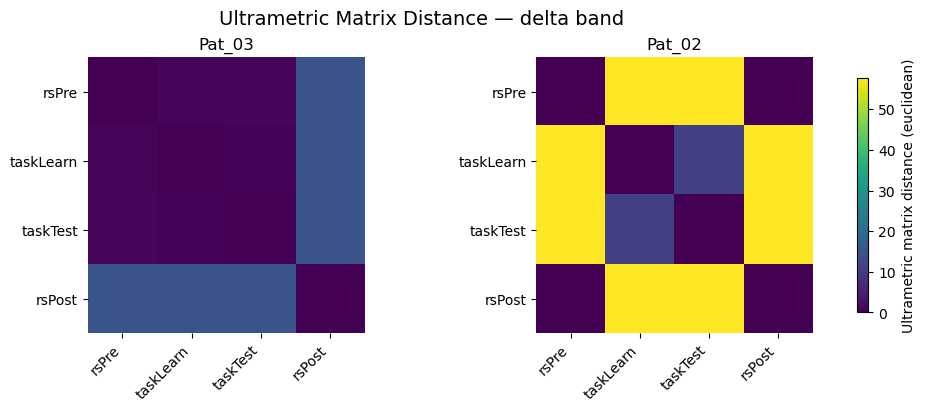

Saved: data/figures/DSTCMP_all_distance_measures/ultrametric_matrix_distance/delta.png


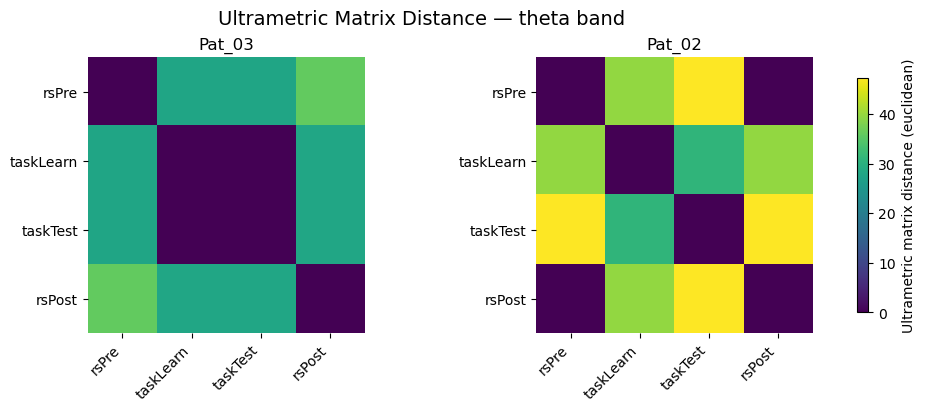

Saved: data/figures/DSTCMP_all_distance_measures/ultrametric_matrix_distance/theta.png


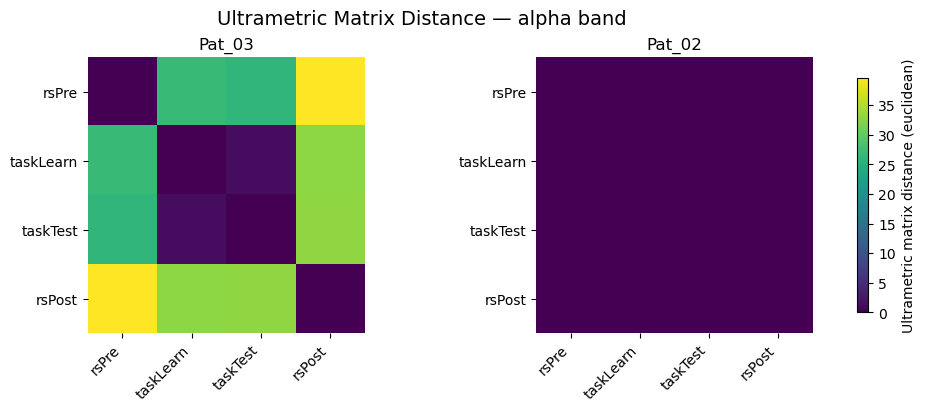

Saved: data/figures/DSTCMP_all_distance_measures/ultrametric_matrix_distance/alpha.png


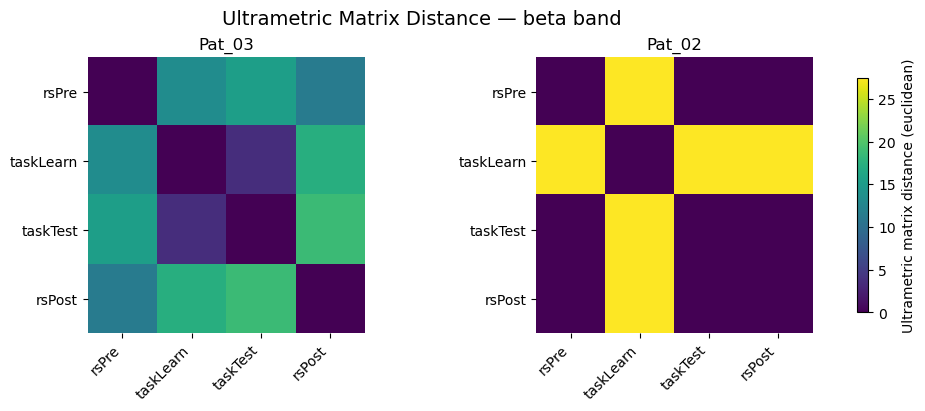

Saved: data/figures/DSTCMP_all_distance_measures/ultrametric_matrix_distance/beta.png


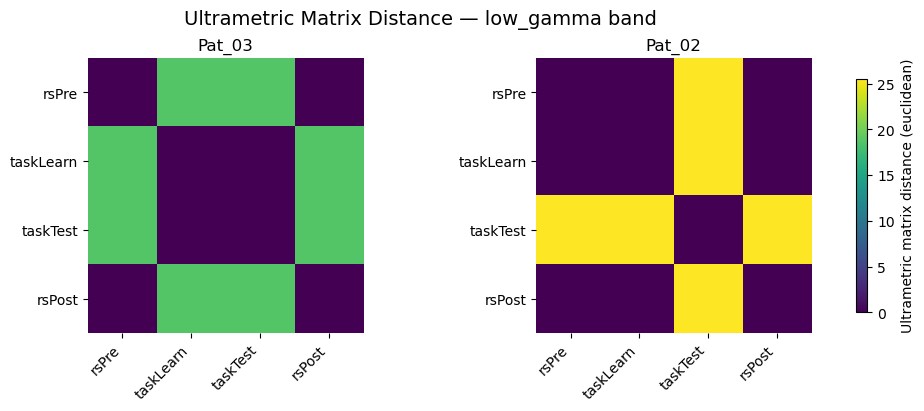

Saved: data/figures/DSTCMP_all_distance_measures/ultrametric_matrix_distance/low_gamma.png


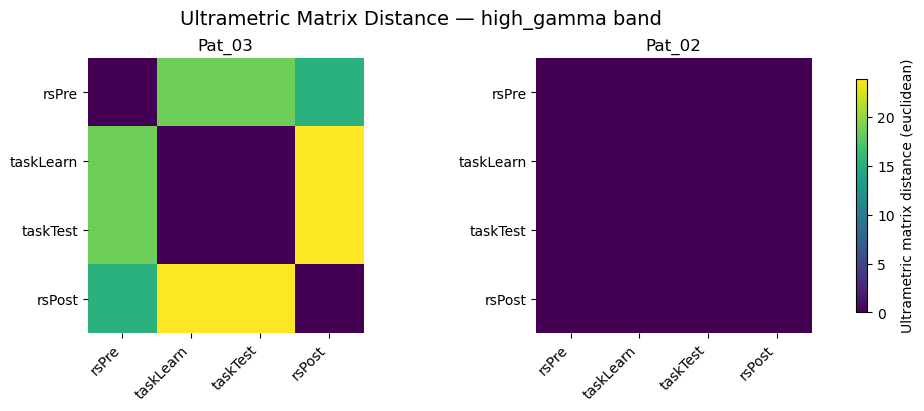

Saved: data/figures/DSTCMP_all_distance_measures/ultrametric_matrix_distance/high_gamma.png

=== Ultrametric Scaled Distance (log) ===


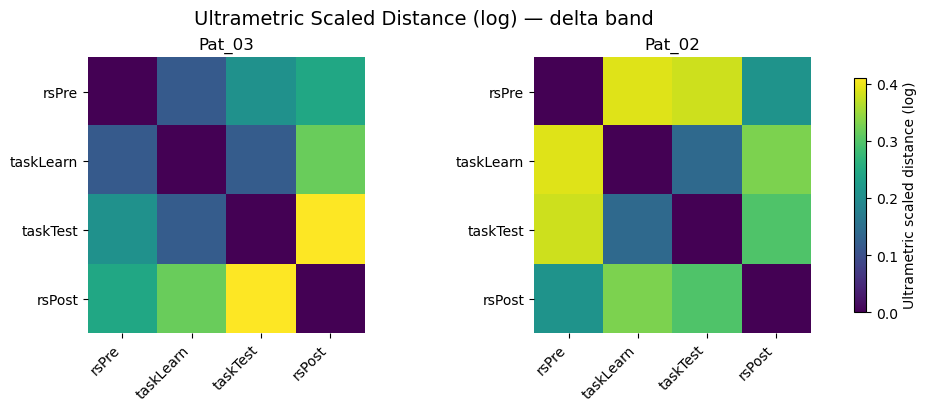

Saved: data/figures/DSTCMP_all_distance_measures/ultrametric_scaled_distance_log/delta.png


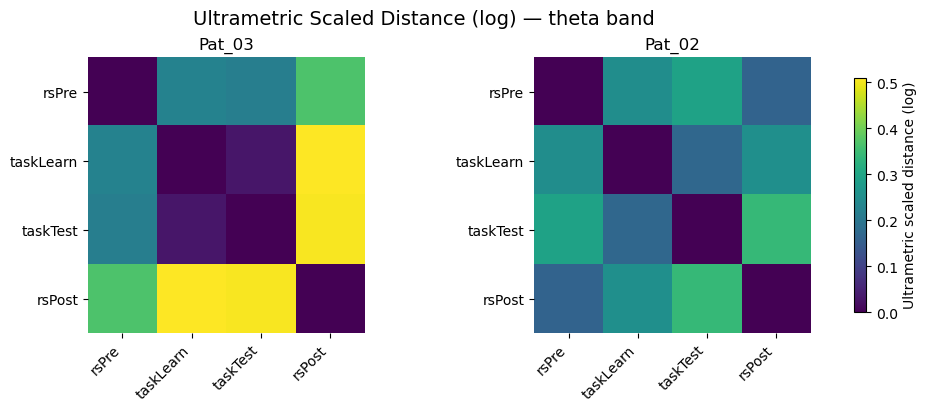

Saved: data/figures/DSTCMP_all_distance_measures/ultrametric_scaled_distance_log/theta.png


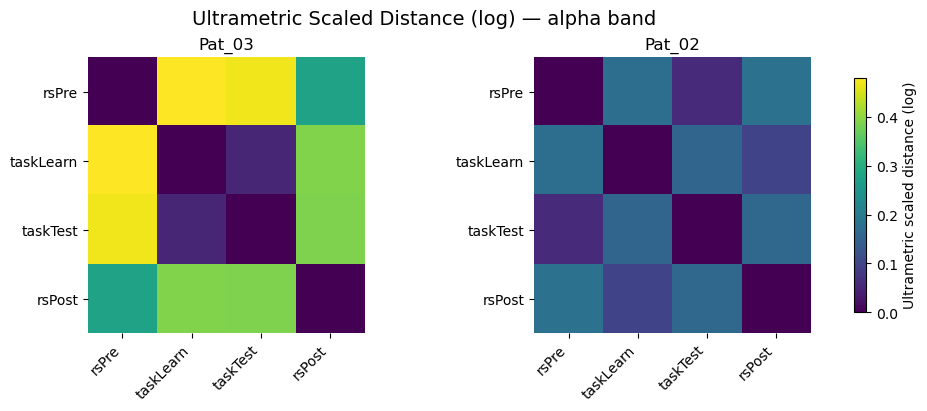

Saved: data/figures/DSTCMP_all_distance_measures/ultrametric_scaled_distance_log/alpha.png


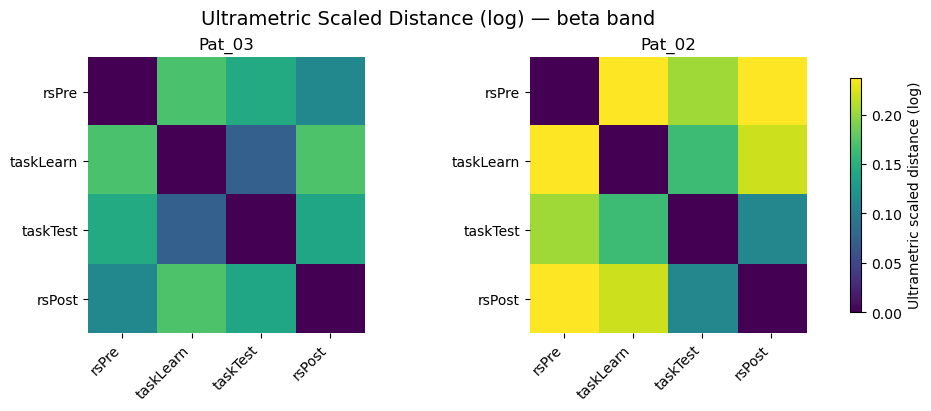

Saved: data/figures/DSTCMP_all_distance_measures/ultrametric_scaled_distance_log/beta.png


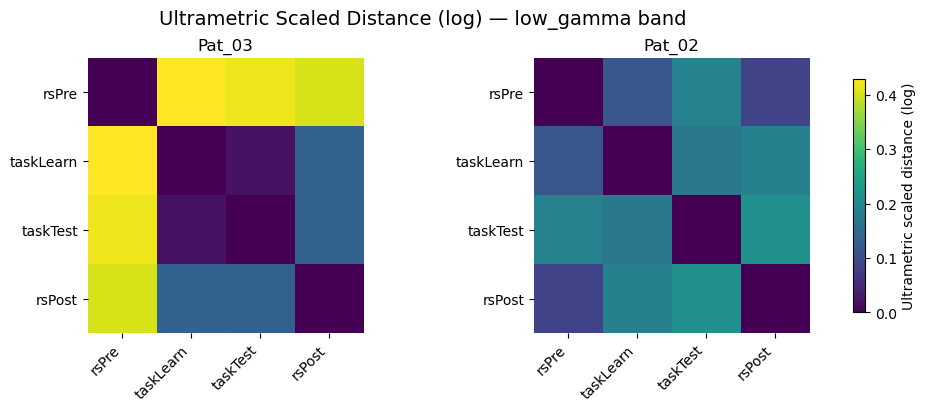

Saved: data/figures/DSTCMP_all_distance_measures/ultrametric_scaled_distance_log/low_gamma.png


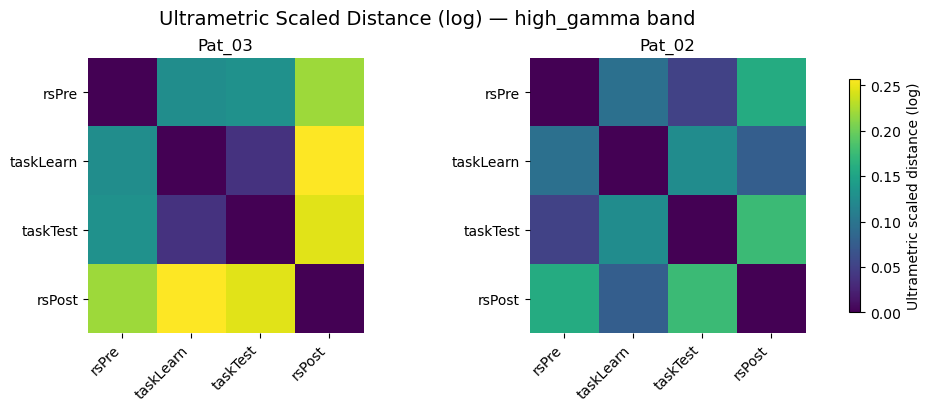

Saved: data/figures/DSTCMP_all_distance_measures/ultrametric_scaled_distance_log/high_gamma.png

=== Ultrametric Rank Correlation (1 - spearman) ===


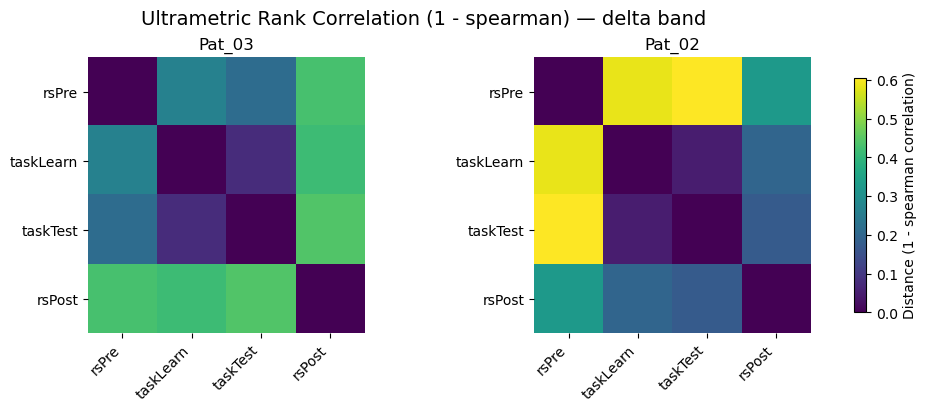

Saved: data/figures/DSTCMP_all_distance_measures/ultrametric_rank_correlation_spearman/delta.png


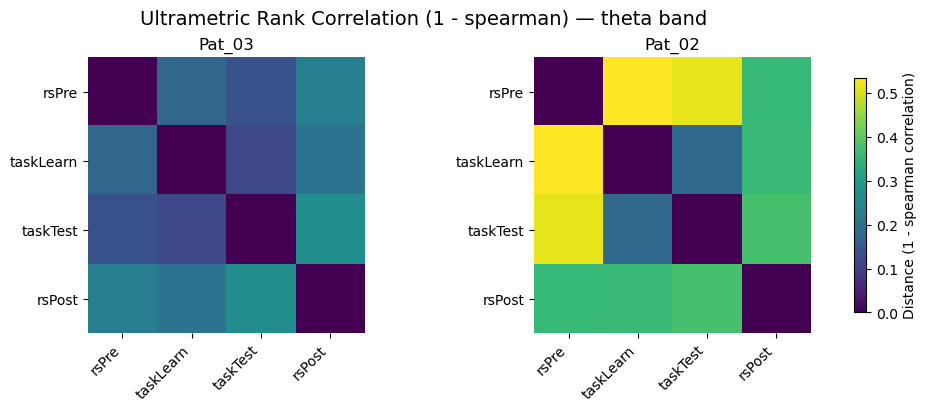

Saved: data/figures/DSTCMP_all_distance_measures/ultrametric_rank_correlation_spearman/theta.png


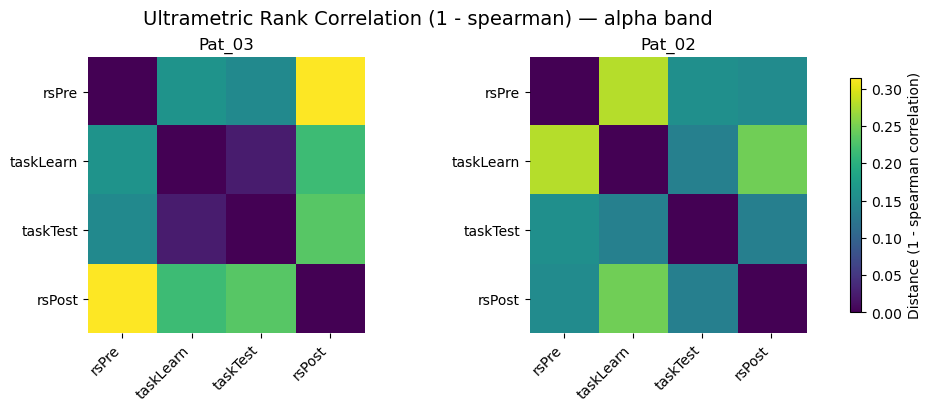

Saved: data/figures/DSTCMP_all_distance_measures/ultrametric_rank_correlation_spearman/alpha.png


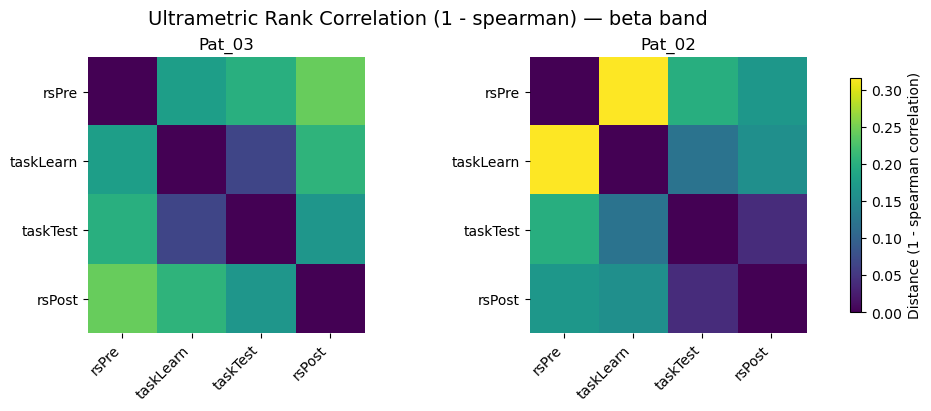

Saved: data/figures/DSTCMP_all_distance_measures/ultrametric_rank_correlation_spearman/beta.png


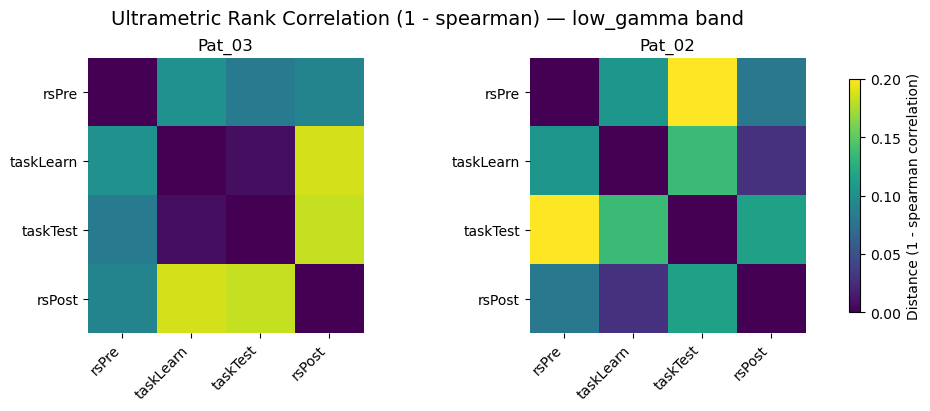

Saved: data/figures/DSTCMP_all_distance_measures/ultrametric_rank_correlation_spearman/low_gamma.png


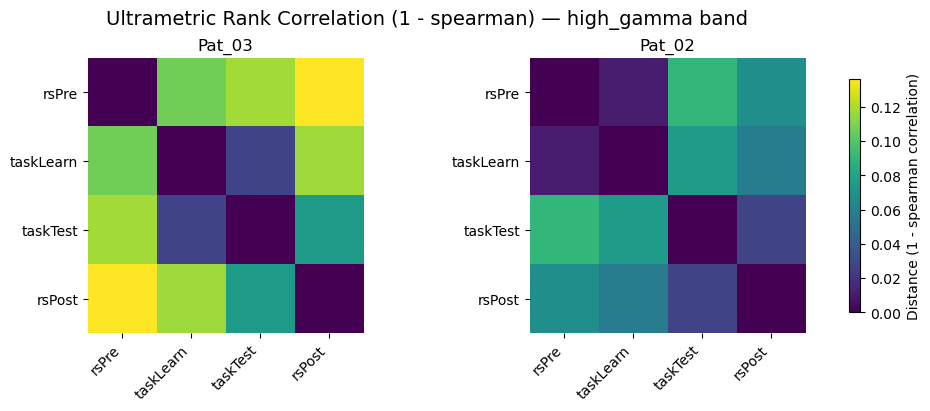

Saved: data/figures/DSTCMP_all_distance_measures/ultrametric_rank_correlation_spearman/high_gamma.png

=== Ultrametric Quantile RMSE (log) ===


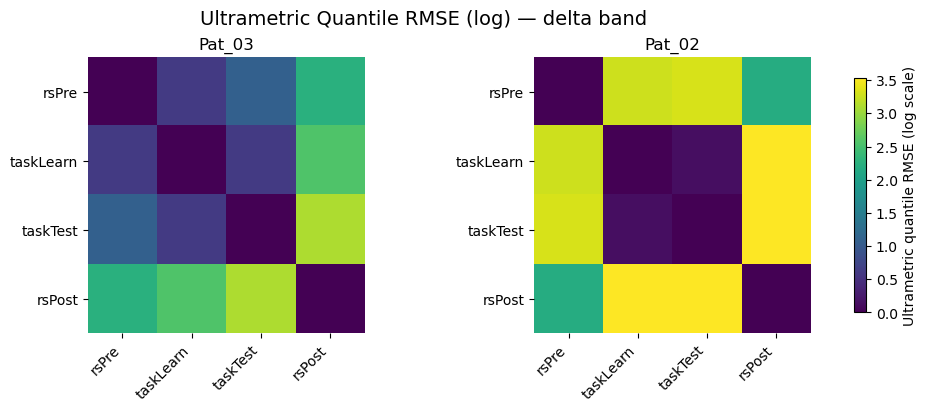

Saved: data/figures/DSTCMP_all_distance_measures/ultrametric_quantile_rmse_log/delta.png


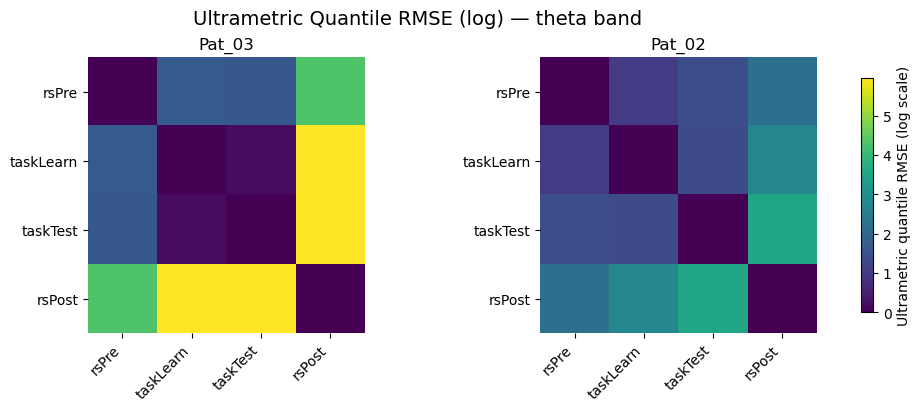

Saved: data/figures/DSTCMP_all_distance_measures/ultrametric_quantile_rmse_log/theta.png


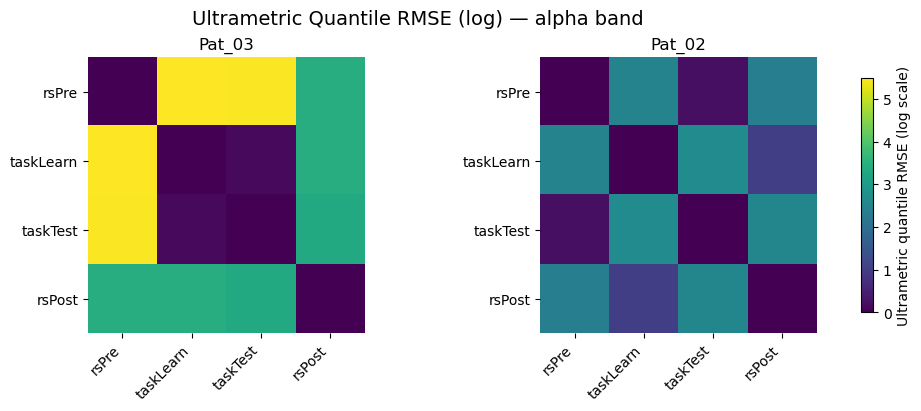

Saved: data/figures/DSTCMP_all_distance_measures/ultrametric_quantile_rmse_log/alpha.png


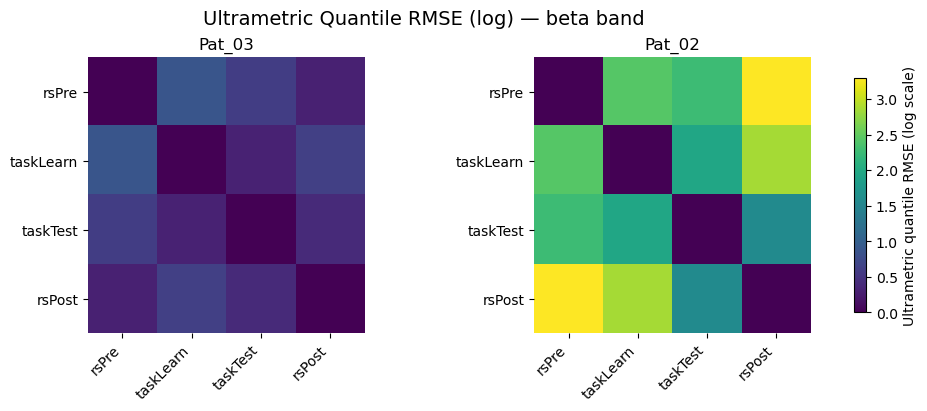

Saved: data/figures/DSTCMP_all_distance_measures/ultrametric_quantile_rmse_log/beta.png


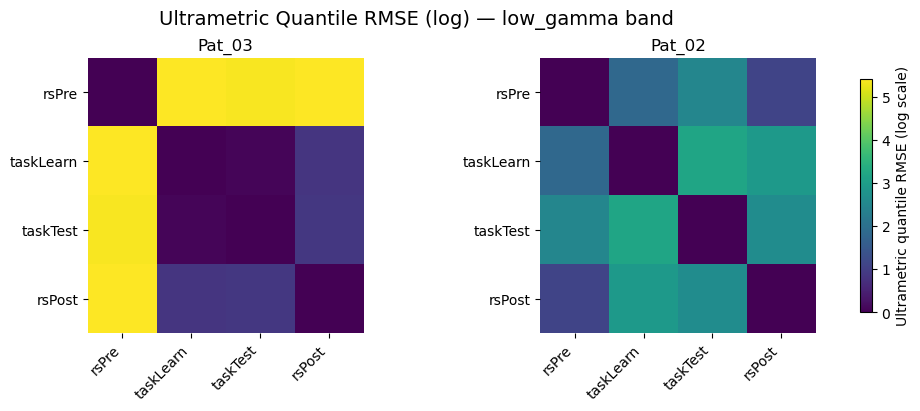

Saved: data/figures/DSTCMP_all_distance_measures/ultrametric_quantile_rmse_log/low_gamma.png


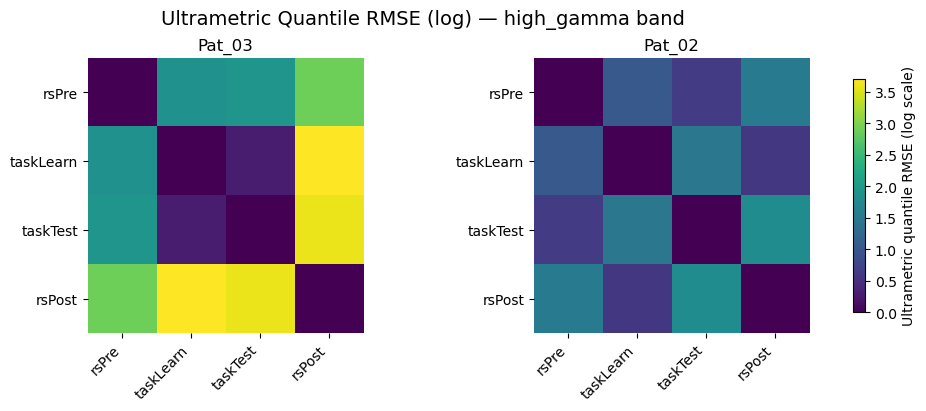

Saved: data/figures/DSTCMP_all_distance_measures/ultrametric_quantile_rmse_log/high_gamma.png

=== Ultrametric Distance (Permutation Robust) ===


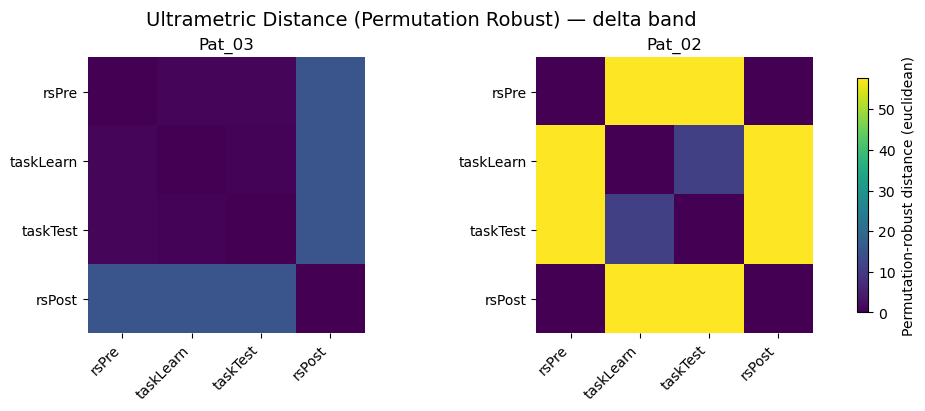

Saved: data/figures/DSTCMP_all_distance_measures/ultrametric_distance_permutation_robust/delta.png


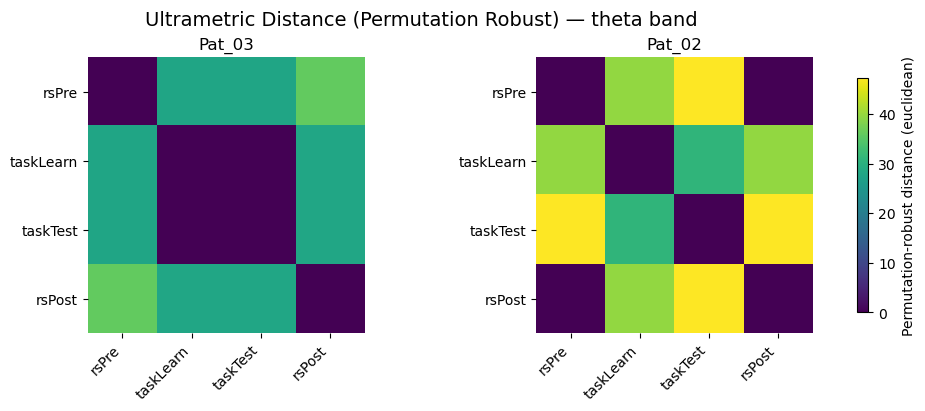

Saved: data/figures/DSTCMP_all_distance_measures/ultrametric_distance_permutation_robust/theta.png


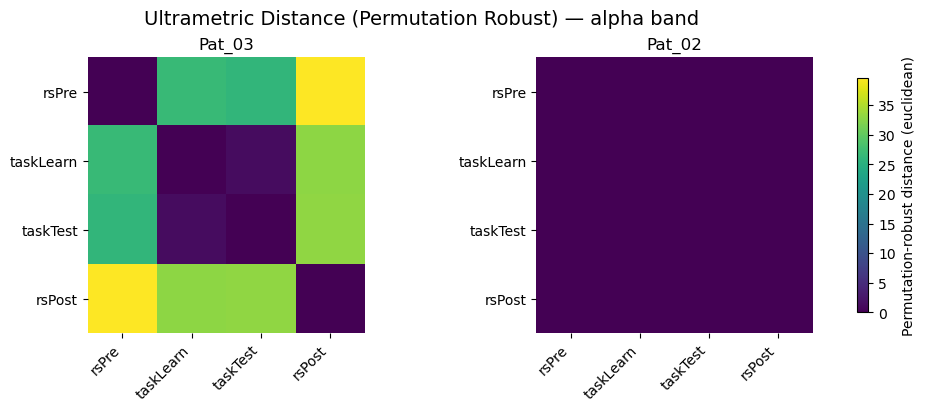

Saved: data/figures/DSTCMP_all_distance_measures/ultrametric_distance_permutation_robust/alpha.png


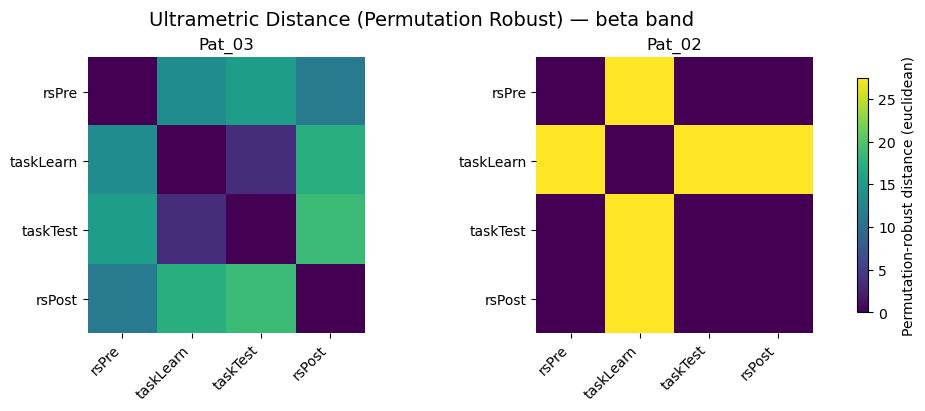

Saved: data/figures/DSTCMP_all_distance_measures/ultrametric_distance_permutation_robust/beta.png


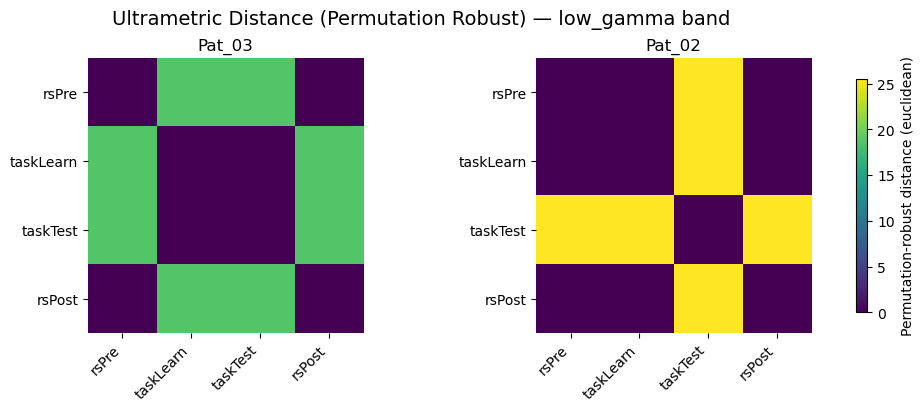

Saved: data/figures/DSTCMP_all_distance_measures/ultrametric_distance_permutation_robust/low_gamma.png


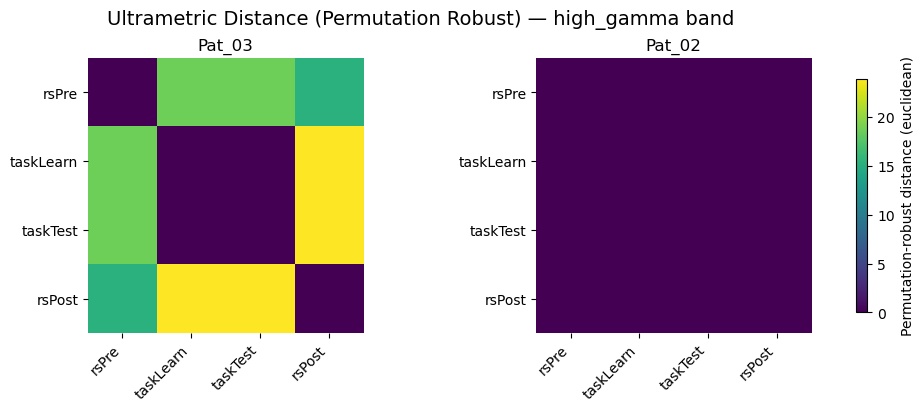

Saved: data/figures/DSTCMP_all_distance_measures/ultrametric_distance_permutation_robust/high_gamma.png

=== Robinson–Foulds Distance ===


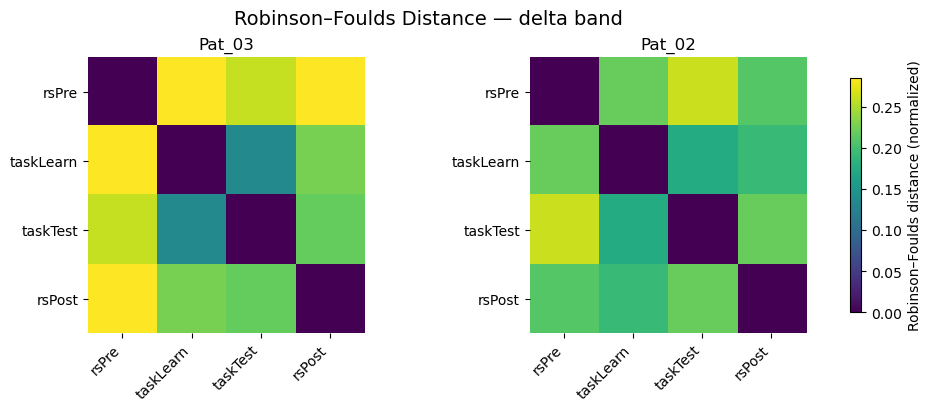

Saved: data/figures/DSTCMP_all_distance_measures/tree_robinson_foulds/delta.png


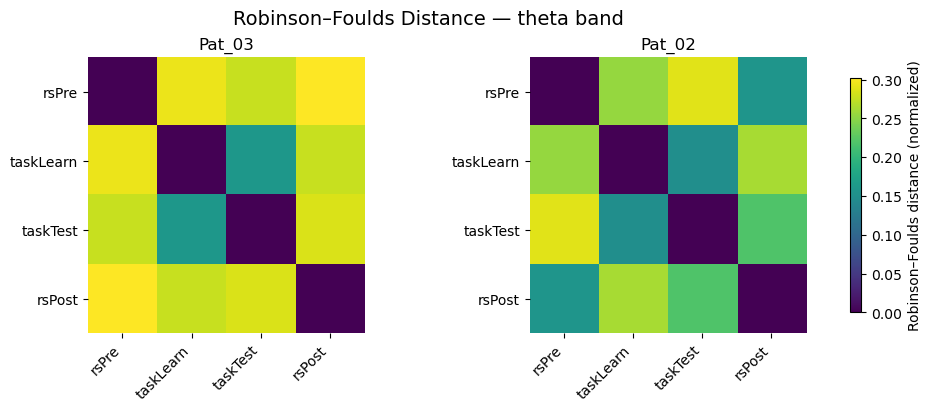

Saved: data/figures/DSTCMP_all_distance_measures/tree_robinson_foulds/theta.png


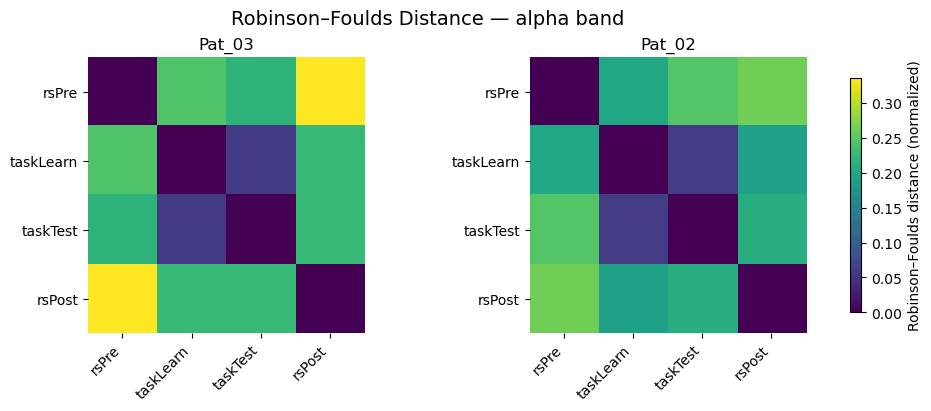

Saved: data/figures/DSTCMP_all_distance_measures/tree_robinson_foulds/alpha.png


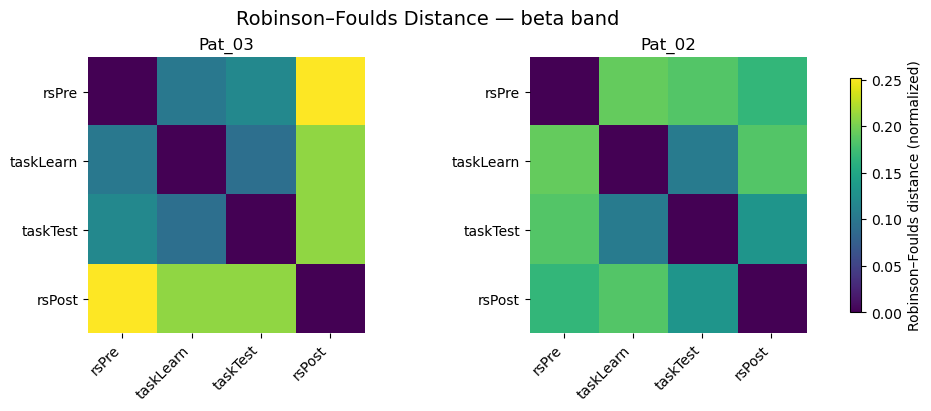

Saved: data/figures/DSTCMP_all_distance_measures/tree_robinson_foulds/beta.png


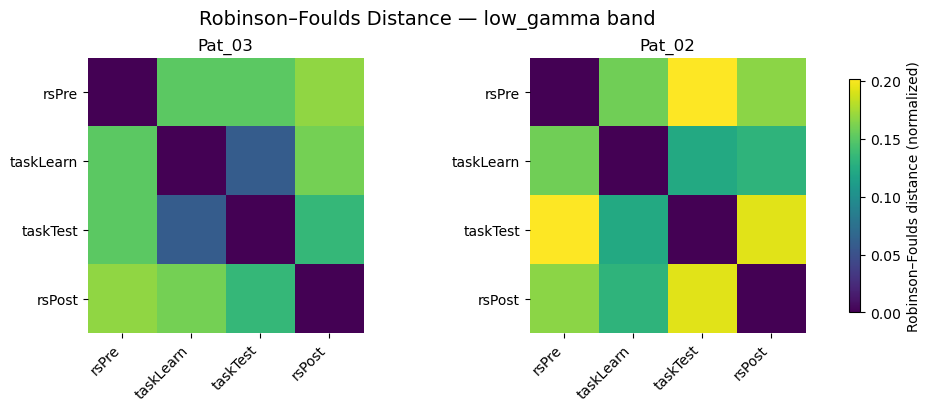

Saved: data/figures/DSTCMP_all_distance_measures/tree_robinson_foulds/low_gamma.png


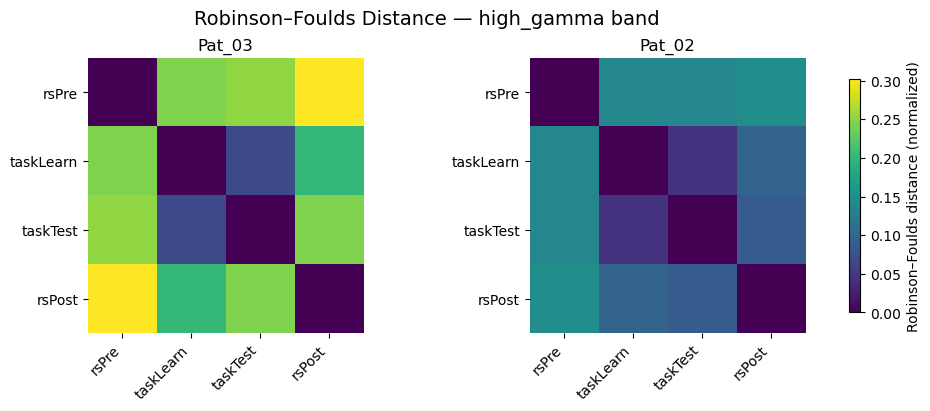

Saved: data/figures/DSTCMP_all_distance_measures/tree_robinson_foulds/high_gamma.png

=== Cophenetic Correlation (distance) ===


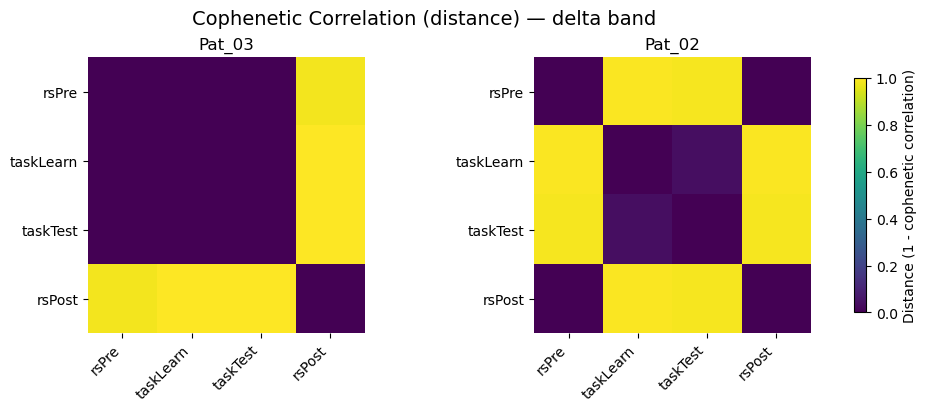

Saved: data/figures/DSTCMP_all_distance_measures/tree_cophenetic_distance/delta.png


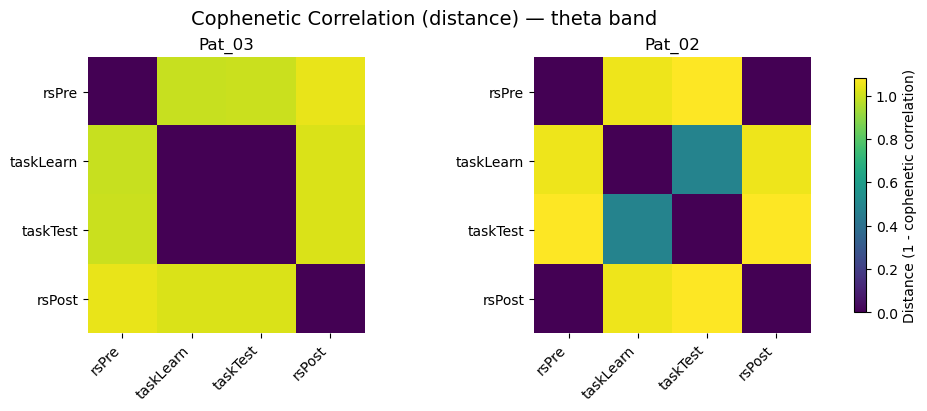

Saved: data/figures/DSTCMP_all_distance_measures/tree_cophenetic_distance/theta.png


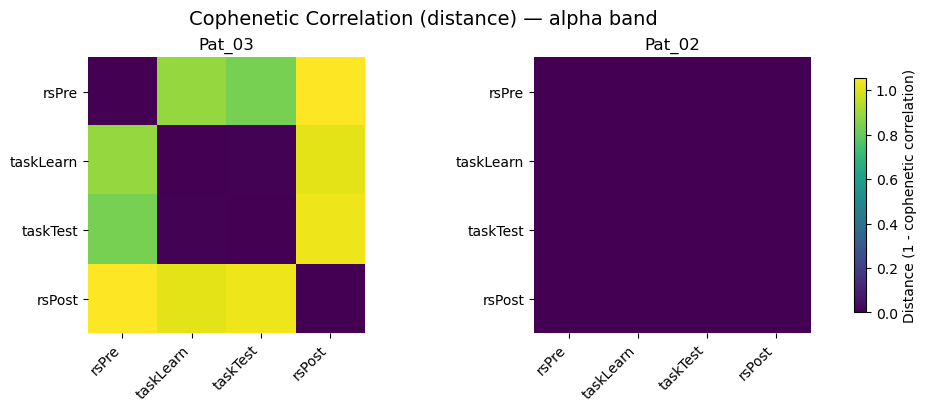

Saved: data/figures/DSTCMP_all_distance_measures/tree_cophenetic_distance/alpha.png


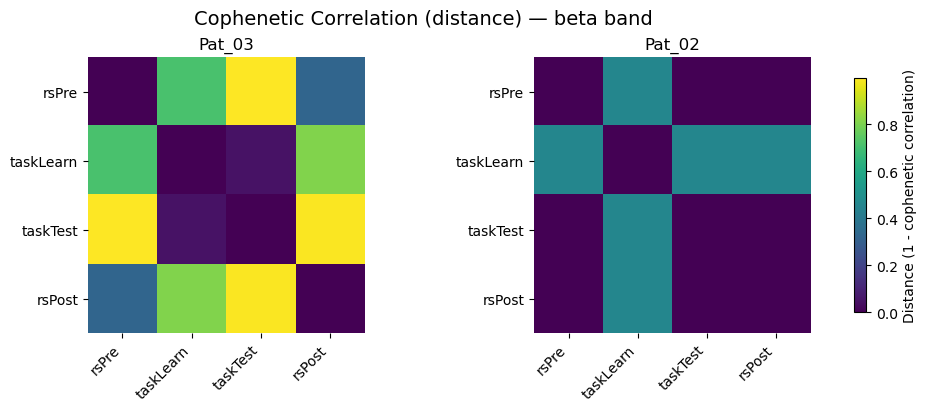

Saved: data/figures/DSTCMP_all_distance_measures/tree_cophenetic_distance/beta.png


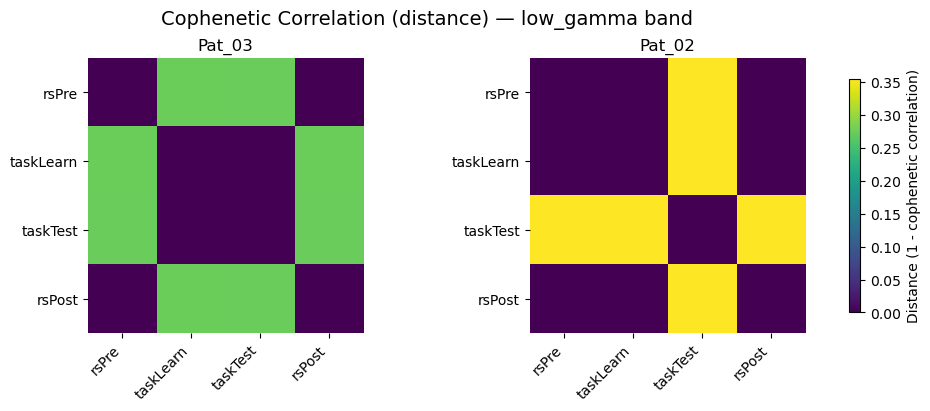

Saved: data/figures/DSTCMP_all_distance_measures/tree_cophenetic_distance/low_gamma.png


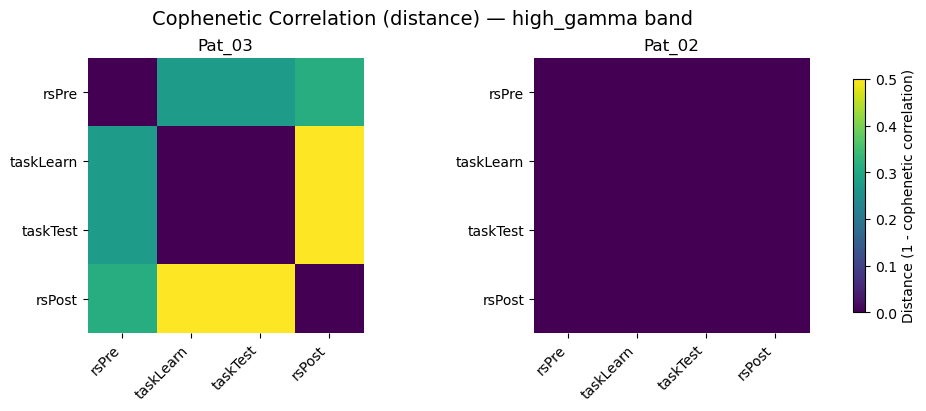

Saved: data/figures/DSTCMP_all_distance_measures/tree_cophenetic_distance/high_gamma.png

=== Baker's Gamma (distance) ===


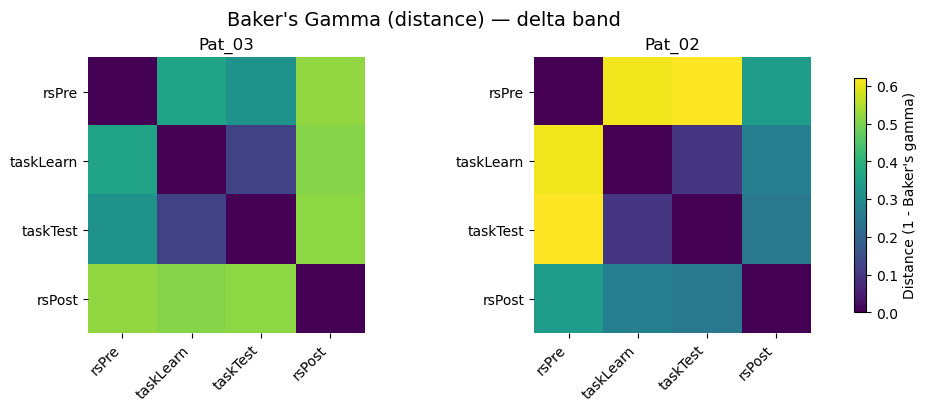

Saved: data/figures/DSTCMP_all_distance_measures/tree_baker_gamma_distance/delta.png


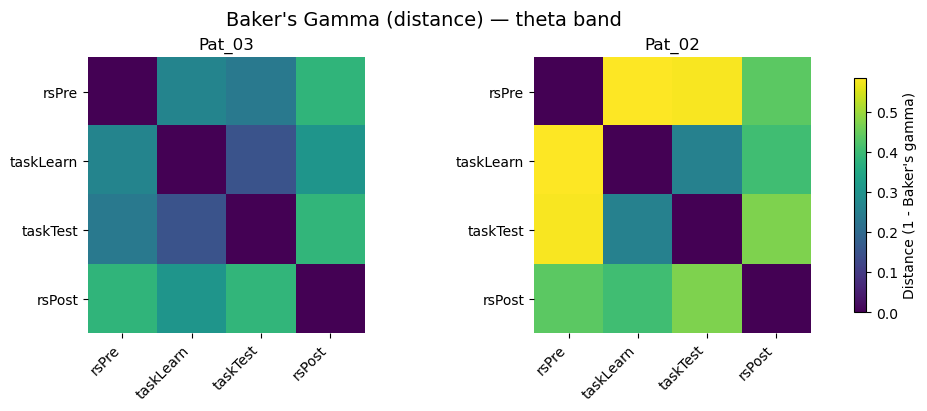

Saved: data/figures/DSTCMP_all_distance_measures/tree_baker_gamma_distance/theta.png


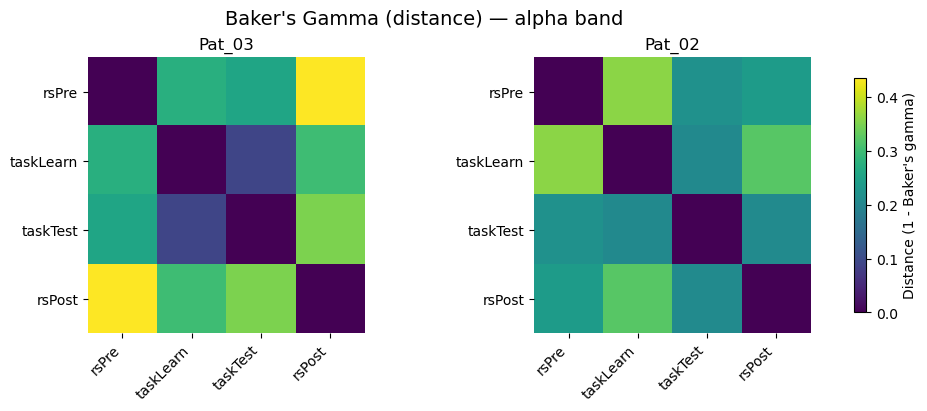

Saved: data/figures/DSTCMP_all_distance_measures/tree_baker_gamma_distance/alpha.png


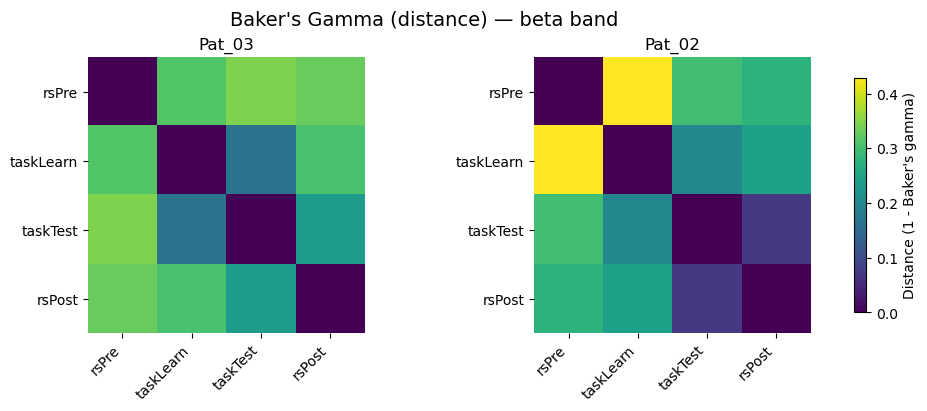

Saved: data/figures/DSTCMP_all_distance_measures/tree_baker_gamma_distance/beta.png


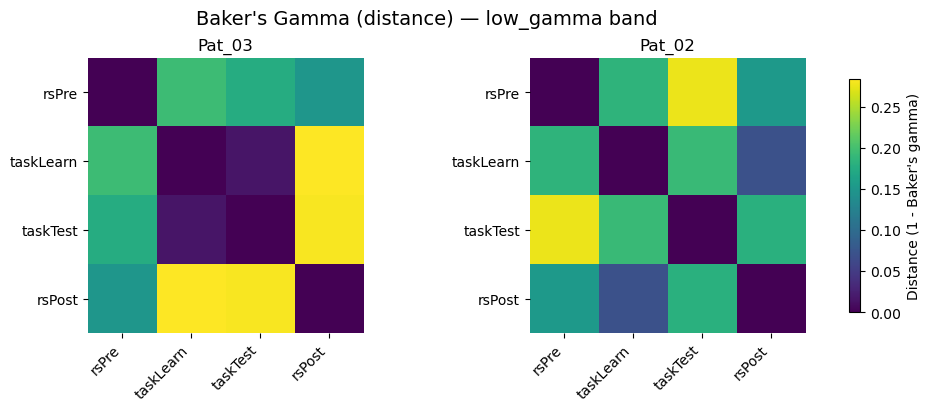

Saved: data/figures/DSTCMP_all_distance_measures/tree_baker_gamma_distance/low_gamma.png


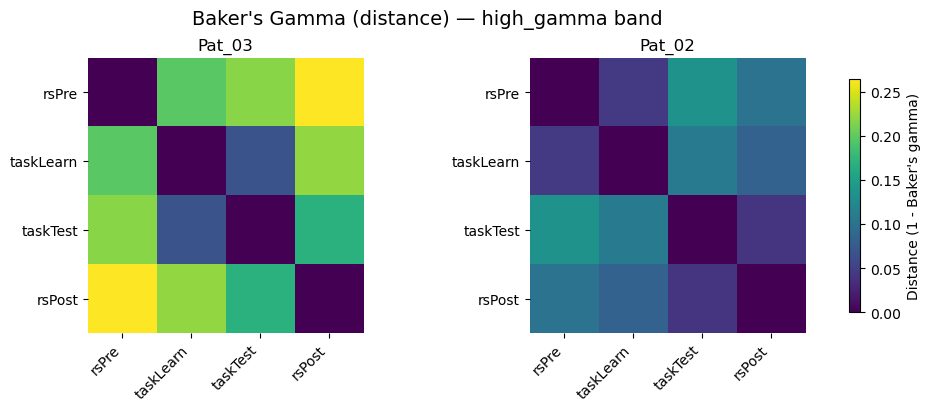

Saved: data/figures/DSTCMP_all_distance_measures/tree_baker_gamma_distance/high_gamma.png

=== Fowlkes–Mallows Index (distance) ===


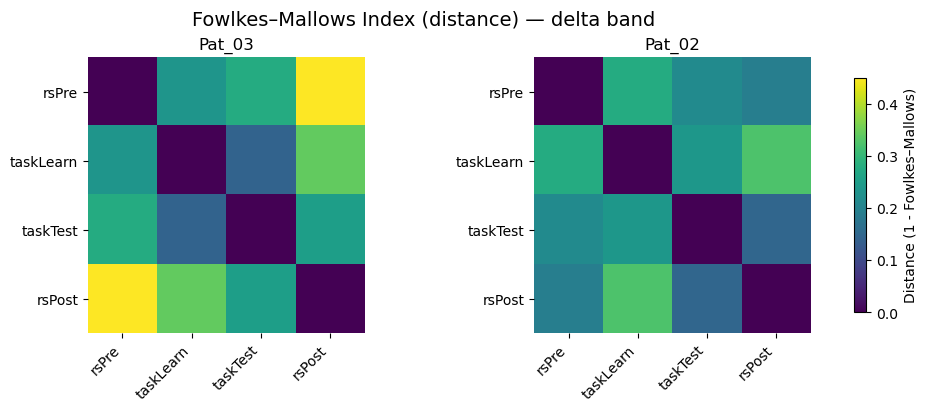

Saved: data/figures/DSTCMP_all_distance_measures/tree_fowlkes_mallows_distance/delta.png


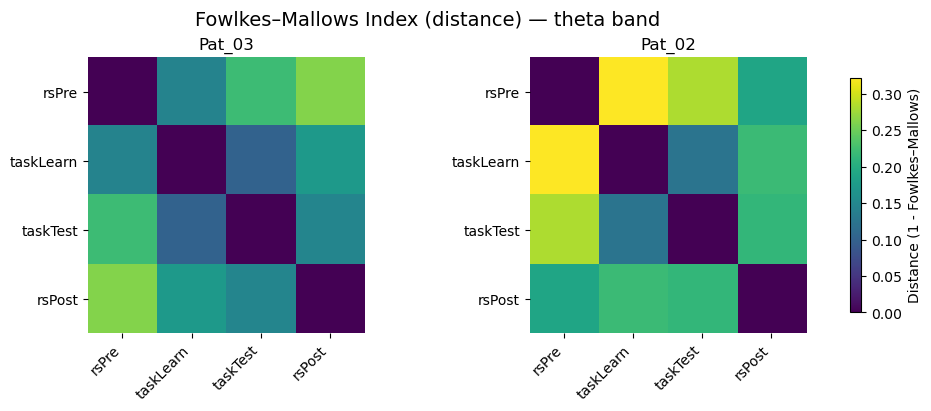

Saved: data/figures/DSTCMP_all_distance_measures/tree_fowlkes_mallows_distance/theta.png


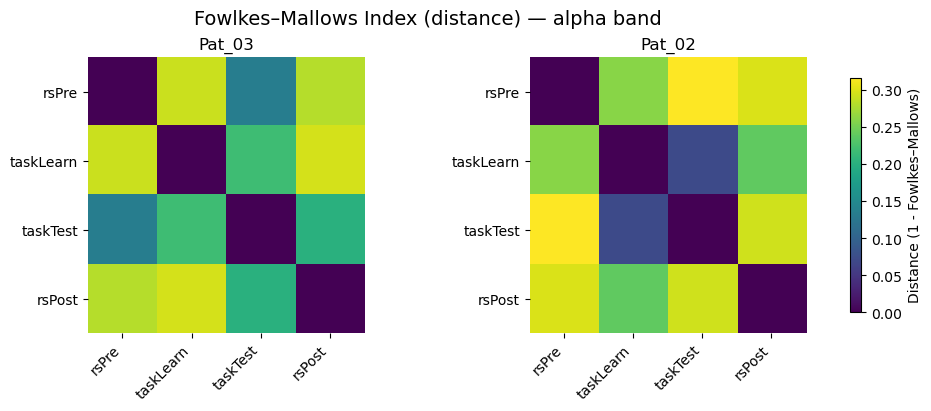

Saved: data/figures/DSTCMP_all_distance_measures/tree_fowlkes_mallows_distance/alpha.png


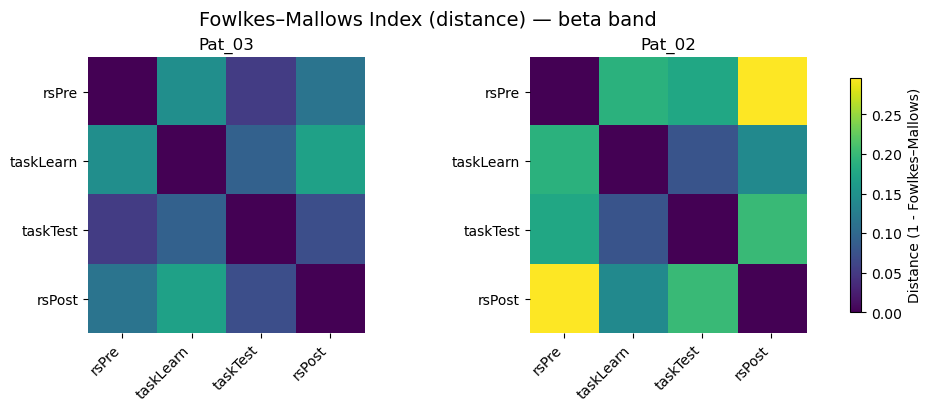

Saved: data/figures/DSTCMP_all_distance_measures/tree_fowlkes_mallows_distance/beta.png


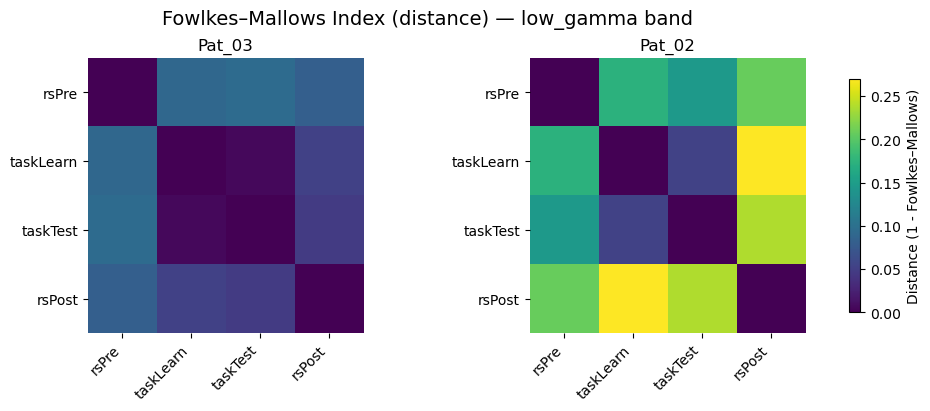

Saved: data/figures/DSTCMP_all_distance_measures/tree_fowlkes_mallows_distance/low_gamma.png


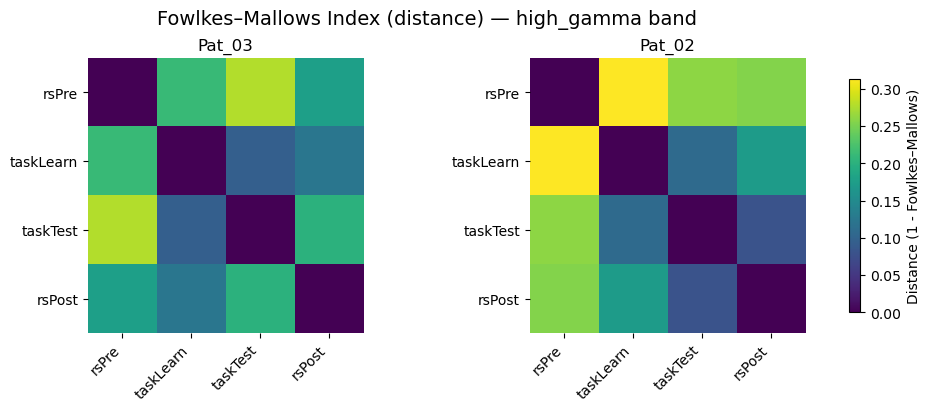

Saved: data/figures/DSTCMP_all_distance_measures/tree_fowlkes_mallows_distance/high_gamma.png
✓ All figures generated


In [8]:
for measure_key, spec in plot_specs.items():
    print(f"\n=== {spec['label']} ===")
    plot_measure_across_patients(measure_key, spec['label'], spec['cbar'])

print('✓ All figures generated')


## Cross-Patient Measure Consistency Analysis

Identify which distance measure produces the most similar/comparable results across patients.
For each measure and band, we compute:
1. **Correlation** between patient distance matrices
2. **Normalized difference** (Frobenius norm of difference / average Frobenius norm)
3. **Rank consistency** (how similarly each measure ranks phase pairs)

In [9]:
from scipy.stats import spearmanr, pearsonr
from scipy.spatial.distance import squareform

def compute_cross_patient_consistency(M1, M2):
    """
    Compute consistency metrics between two patient distance matrices.
    
    Returns:
        corr_pearson: Pearson correlation of upper triangular elements
        corr_spearman: Spearman rank correlation of upper triangular elements
        norm_diff: Normalized Frobenius distance
    """
    # Get upper triangular elements (excluding diagonal)
    mask = np.triu(np.ones_like(M1, dtype=bool), k=1)
    v1 = M1[mask]
    v2 = M2[mask]
    
    # Remove NaN pairs
    valid = np.isfinite(v1) & np.isfinite(v2)
    if valid.sum() < 2:
        return np.nan, np.nan, np.nan
    
    v1_clean = v1[valid]
    v2_clean = v2[valid]
    
    # Pearson correlation
    try:
        corr_p, _ = pearsonr(v1_clean, v2_clean)
    except:
        corr_p = np.nan
    
    # Spearman correlation
    try:
        corr_s, _ = spearmanr(v1_clean, v2_clean)
    except:
        corr_s = np.nan
    
    # Normalized Frobenius difference
    diff = np.linalg.norm(v1_clean - v2_clean)
    avg_norm = (np.linalg.norm(v1_clean) + np.linalg.norm(v2_clean)) / 2
    norm_diff = diff / avg_norm if avg_norm > 0 else np.nan
    
    return corr_p, corr_s, norm_diff

# Compute consistency for each measure across patients
consistency_results = {}

for measure_key in measure_results.keys():
    consistency_results[measure_key] = {
        'pearson': {},
        'spearman': {},
        'norm_diff': {},
    }
    
    for band in bands:
        # Get matrices for both patients
        if len(patients) < 2:
            continue
        
        M1 = measure_results[measure_key][band][patients[0]]
        M2 = measure_results[measure_key][band][patients[1]]
        
        corr_p, corr_s, norm_diff = compute_cross_patient_consistency(M1, M2)
        
        consistency_results[measure_key]['pearson'][band] = corr_p
        consistency_results[measure_key]['spearman'][band] = corr_s
        consistency_results[measure_key]['norm_diff'][band] = norm_diff

print('✓ Cross-patient consistency computed for all measures')

✓ Cross-patient consistency computed for all measures


In [10]:
# Create summary table of consistency across all measures
print("\n" + "="*80)
print("CROSS-PATIENT CONSISTENCY SUMMARY")
print("="*80)
print(f"\nComparing {patients[0]} vs {patients[1]}")
print("\nHigher Pearson/Spearman correlation = more similar pattern across patients")
print("Lower normalized difference = more comparable magnitudes across patients")
print("\n" + "-"*80)

for measure_key, spec in plot_specs.items():
    print(f"\n{spec['label']}:")
    print("  Band         Pearson    Spearman   Norm.Diff")
    print("  " + "-"*50)
    
    for band in bands:
        corr_p = consistency_results[measure_key]['pearson'][band]
        corr_s = consistency_results[measure_key]['spearman'][band]
        norm_d = consistency_results[measure_key]['norm_diff'][band]
        
        print(f"  {band:12s} {corr_p:8.4f}   {corr_s:8.4f}   {norm_d:8.4f}")


CROSS-PATIENT CONSISTENCY SUMMARY

Comparing Pat_03 vs Pat_02

Higher Pearson/Spearman correlation = more similar pattern across patients
Lower normalized difference = more comparable magnitudes across patients

--------------------------------------------------------------------------------

Ultrametric Matrix Distance:
  Band         Pearson    Spearman   Norm.Diff
  --------------------------------------------------
  delta         -0.0624     0.4286     1.4334
  theta         -0.1653     0.0857     0.7183
  alpha          0.6589     0.9429     2.0000
  beta          -0.3848    -0.3714     0.9705
  low_gamma      0.0002     0.2000     0.9308
  high_gamma     0.4801     0.0857     1.9908

Ultrametric Scaled Distance (log):
  Band         Pearson    Spearman   Norm.Diff
  --------------------------------------------------
  delta          0.1214    -0.2571     0.4984
  theta          0.4869     0.3143     0.5390
  alpha         -0.3631    -0.2000     1.0254
  beta           0.3162   

In [11]:
# Compute aggregate scores across all bands for each measure
measure_scores = {}

for measure_key in measure_results.keys():
    # Average Pearson correlation across bands
    pearson_vals = [consistency_results[measure_key]['pearson'][b] 
                   for b in bands]
    pearson_vals = [v for v in pearson_vals if np.isfinite(v)]
    avg_pearson = np.mean(pearson_vals) if pearson_vals else np.nan
    
    # Average Spearman correlation across bands
    spearman_vals = [consistency_results[measure_key]['spearman'][b] 
                    for b in bands]
    spearman_vals = [v for v in spearman_vals if np.isfinite(v)]
    avg_spearman = np.mean(spearman_vals) if spearman_vals else np.nan
    
    # Average normalized difference across bands
    normdiff_vals = [consistency_results[measure_key]['norm_diff'][b] 
                    for b in bands]
    normdiff_vals = [v for v in normdiff_vals if np.isfinite(v)]
    avg_normdiff = np.mean(normdiff_vals) if normdiff_vals else np.nan
    
    # Combined score: higher is better (high correlation, low difference)
    # Score = (avg_pearson + avg_spearman) / 2 - 0.5 * avg_normdiff
    if np.isfinite(avg_pearson) and np.isfinite(avg_spearman) and np.isfinite(avg_normdiff):
        combined_score = (avg_pearson + avg_spearman) / 2 - 0.5 * avg_normdiff
    else:
        combined_score = np.nan
    
    measure_scores[measure_key] = {
        'avg_pearson': avg_pearson,
        'avg_spearman': avg_spearman,
        'avg_normdiff': avg_normdiff,
        'combined_score': combined_score,
    }

# Sort by combined score (descending)
sorted_measures = sorted(
    [(k, v['combined_score']) for k, v in measure_scores.items()],
    key=lambda x: x[1] if np.isfinite(x[1]) else -np.inf,
    reverse=True
)

print("\n" + "="*80)
print("RANKING: MOST CONSISTENT MEASURES ACROSS PATIENTS")
print("="*80)
print("\nRank  Measure                                          Combined Score")
print("-"*80)

for rank, (measure_key, score) in enumerate(sorted_measures, 1):
    label = plot_specs[measure_key]['label']
    print(f"{rank:2d}.   {label:48s} {score:8.4f}")

print("\n" + "="*80)
print("\nBEST MEASURE FOR CROSS-PATIENT COMPARISON:")
best_measure = sorted_measures[0][0]
print(f"  → {plot_specs[best_measure]['label']}")
print("="*80)


RANKING: MOST CONSISTENT MEASURES ACROSS PATIENTS

Rank  Measure                                          Combined Score
--------------------------------------------------------------------------------
 1.   Robinson–Foulds Distance                           0.2909
 2.   Baker's Gamma (distance)                          -0.1423
 3.   Fowlkes–Mallows Index (distance)                  -0.2212
 4.   Ultrametric Scaled Distance (log)                 -0.3138
 5.   Ultrametric Rank Correlation (1 - spearman)       -0.3629
 6.   Cophenetic Correlation (distance)                 -0.4431
 7.   Ultrametric Quantile RMSE (log)                   -0.4462
 8.   Ultrametric Distance (Permutation Robust)         -0.5121
 9.   Ultrametric Matrix Distance                       -0.5121


BEST MEASURE FOR CROSS-PATIENT COMPARISON:
  → Robinson–Foulds Distance


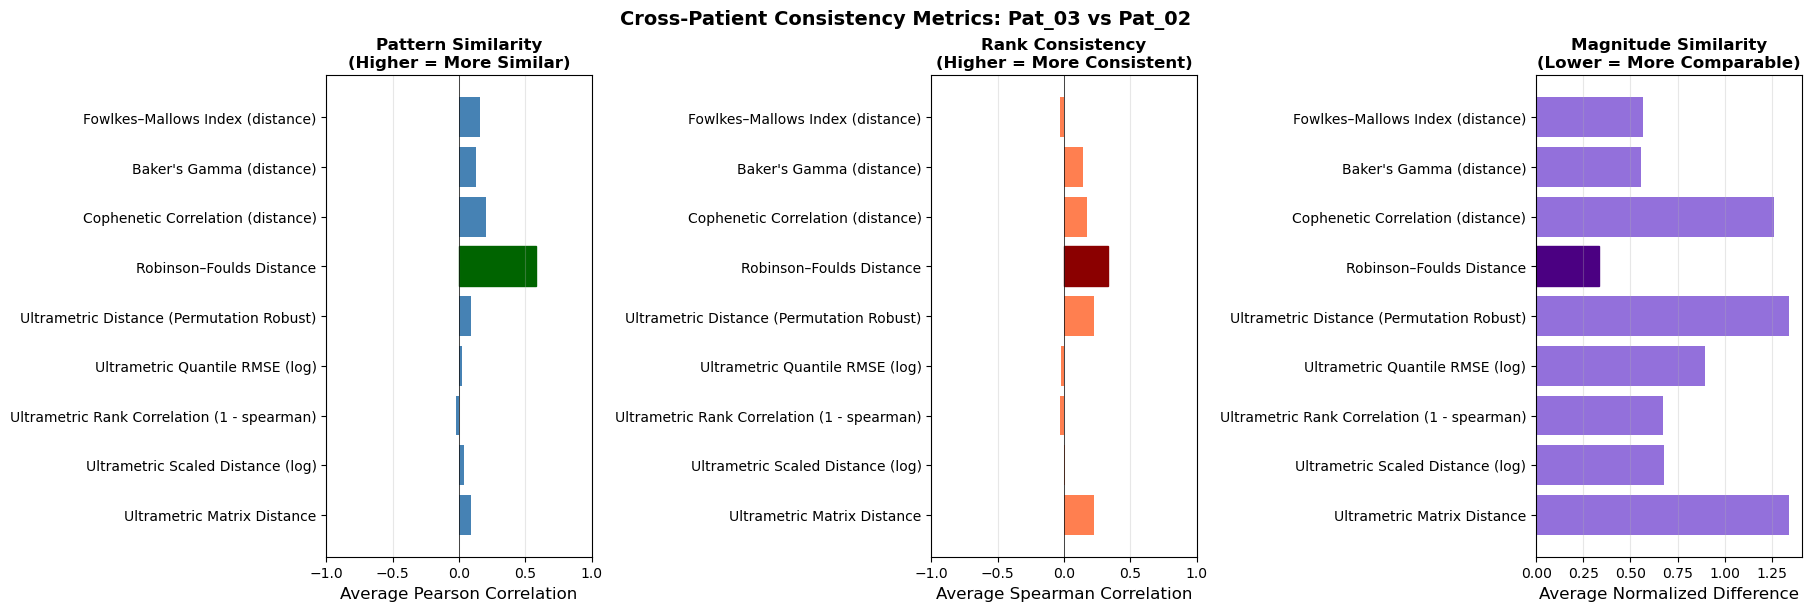

Saved: data/figures/DSTCMP_all_distance_measures/cross_patient_consistency_summary.png


In [12]:
# Visualize consistency metrics across measures
fig, axes = plt.subplots(1, 3, figsize=(18, 6), constrained_layout=True)

measure_labels = [plot_specs[k]['label'] for k in measure_results.keys()]
measure_keys_list = list(measure_results.keys())

# Prepare data for each metric
avg_pearsons = [measure_scores[k]['avg_pearson'] for k in measure_keys_list]
avg_spearmans = [measure_scores[k]['avg_spearman'] for k in measure_keys_list]
avg_normdiffs = [measure_scores[k]['avg_normdiff'] for k in measure_keys_list]

# Plot 1: Average Pearson Correlation
ax = axes[0]
bars = ax.barh(measure_labels, avg_pearsons, color='steelblue')
ax.set_xlabel('Average Pearson Correlation', fontsize=12)
ax.set_title('Pattern Similarity\n(Higher = More Similar)', fontsize=12, fontweight='bold')
ax.axvline(0, color='black', linewidth=0.5)
ax.grid(axis='x', alpha=0.3)
ax.set_xlim(-1, 1)

# Highlight best
best_idx = np.nanargmax(avg_pearsons)
bars[best_idx].set_color('darkgreen')

# Plot 2: Average Spearman Correlation
ax = axes[1]
bars = ax.barh(measure_labels, avg_spearmans, color='coral')
ax.set_xlabel('Average Spearman Correlation', fontsize=12)
ax.set_title('Rank Consistency\n(Higher = More Consistent)', fontsize=12, fontweight='bold')
ax.axvline(0, color='black', linewidth=0.5)
ax.grid(axis='x', alpha=0.3)
ax.set_xlim(-1, 1)

# Highlight best
best_idx = np.nanargmax(avg_spearmans)
bars[best_idx].set_color('darkred')

# Plot 3: Average Normalized Difference
ax = axes[2]
bars = ax.barh(measure_labels, avg_normdiffs, color='mediumpurple')
ax.set_xlabel('Average Normalized Difference', fontsize=12)
ax.set_title('Magnitude Similarity\n(Lower = More Comparable)', fontsize=12, fontweight='bold')
ax.axvline(0, color='black', linewidth=0.5)
ax.grid(axis='x', alpha=0.3)

# Highlight best (lowest)
best_idx = np.nanargmin(avg_normdiffs)
bars[best_idx].set_color('indigo')

fig.suptitle(f'Cross-Patient Consistency Metrics: {patients[0]} vs {patients[1]}', 
             fontsize=14, fontweight='bold')

outfile = path_figs / 'cross_patient_consistency_summary.png'
fig.savefig(outfile, dpi=200, bbox_inches='tight')
plt.show()
print(f'Saved: {outfile}')

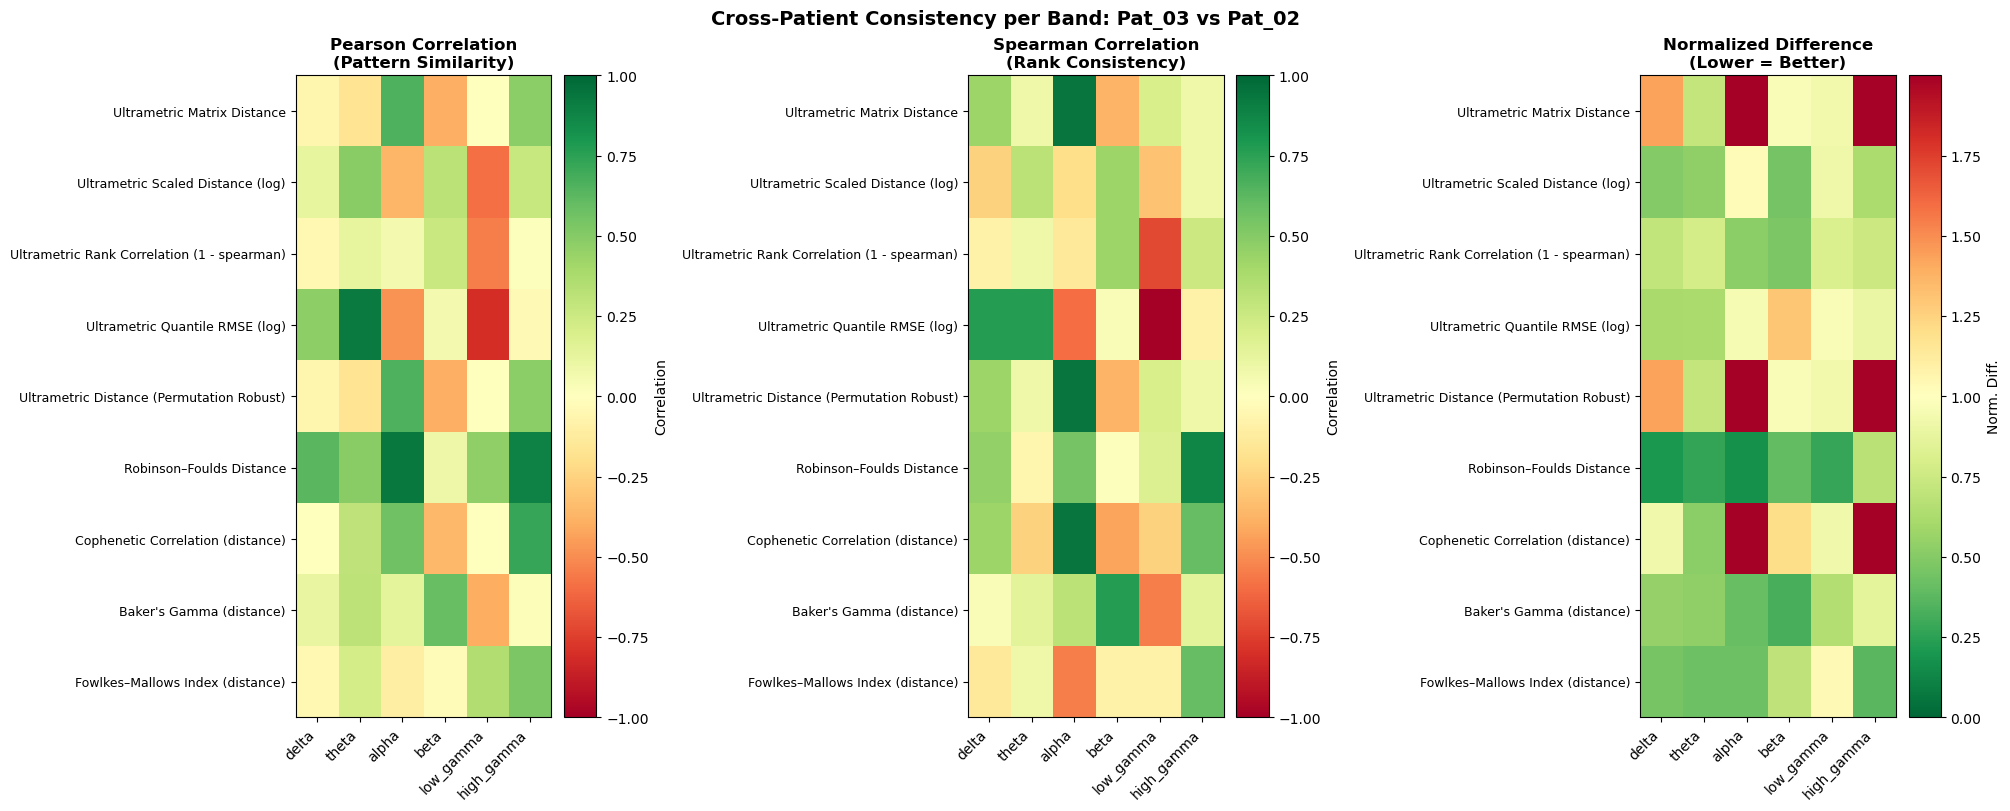

Saved: data/figures/DSTCMP_all_distance_measures/cross_patient_consistency_heatmap.png


In [13]:
# Heatmap: Consistency per measure per band
fig, axes = plt.subplots(1, 3, figsize=(20, 8), constrained_layout=True)

measure_keys_list = list(measure_results.keys())
measure_labels = [plot_specs[k]['label'] for k in measure_keys_list]

# Build matrices for heatmap
n_measures = len(measure_keys_list)
n_bands = len(bands)

pearson_matrix = np.zeros((n_measures, n_bands))
spearman_matrix = np.zeros((n_measures, n_bands))
normdiff_matrix = np.zeros((n_measures, n_bands))

for i, measure_key in enumerate(measure_keys_list):
    for j, band in enumerate(bands):
        pearson_matrix[i, j] = consistency_results[measure_key]['pearson'][band]
        spearman_matrix[i, j] = consistency_results[measure_key]['spearman'][band]
        normdiff_matrix[i, j] = consistency_results[measure_key]['norm_diff'][band]

# Plot Pearson heatmap
ax = axes[0]
im1 = ax.imshow(pearson_matrix, cmap='RdYlGn', aspect='auto', vmin=-1, vmax=1)
ax.set_xticks(range(n_bands))
ax.set_xticklabels(bands, rotation=45, ha='right')
ax.set_yticks(range(n_measures))
ax.set_yticklabels(measure_labels, fontsize=9)
ax.set_title('Pearson Correlation\n(Pattern Similarity)', fontsize=12, fontweight='bold')
plt.colorbar(im1, ax=ax, label='Correlation')

# Plot Spearman heatmap
ax = axes[1]
im2 = ax.imshow(spearman_matrix, cmap='RdYlGn', aspect='auto', vmin=-1, vmax=1)
ax.set_xticks(range(n_bands))
ax.set_xticklabels(bands, rotation=45, ha='right')
ax.set_yticks(range(n_measures))
ax.set_yticklabels(measure_labels, fontsize=9)
ax.set_title('Spearman Correlation\n(Rank Consistency)', fontsize=12, fontweight='bold')
plt.colorbar(im2, ax=ax, label='Correlation')

# Plot Normalized Difference heatmap
ax = axes[2]
vmax_diff = np.nanpercentile(normdiff_matrix, 95)
im3 = ax.imshow(normdiff_matrix, cmap='RdYlGn_r', aspect='auto', vmin=0, vmax=vmax_diff)
ax.set_xticks(range(n_bands))
ax.set_xticklabels(bands, rotation=45, ha='right')
ax.set_yticks(range(n_measures))
ax.set_yticklabels(measure_labels, fontsize=9)
ax.set_title('Normalized Difference\n(Lower = Better)', fontsize=12, fontweight='bold')
plt.colorbar(im3, ax=ax, label='Norm. Diff.')

fig.suptitle(f'Cross-Patient Consistency per Band: {patients[0]} vs {patients[1]}', 
             fontsize=14, fontweight='bold')

outfile = path_figs / 'cross_patient_consistency_heatmap.png'
fig.savefig(outfile, dpi=200, bbox_inches='tight')
plt.show()
print(f'Saved: {outfile}')


DETAILED VIEW: Robinson–Foulds Distance



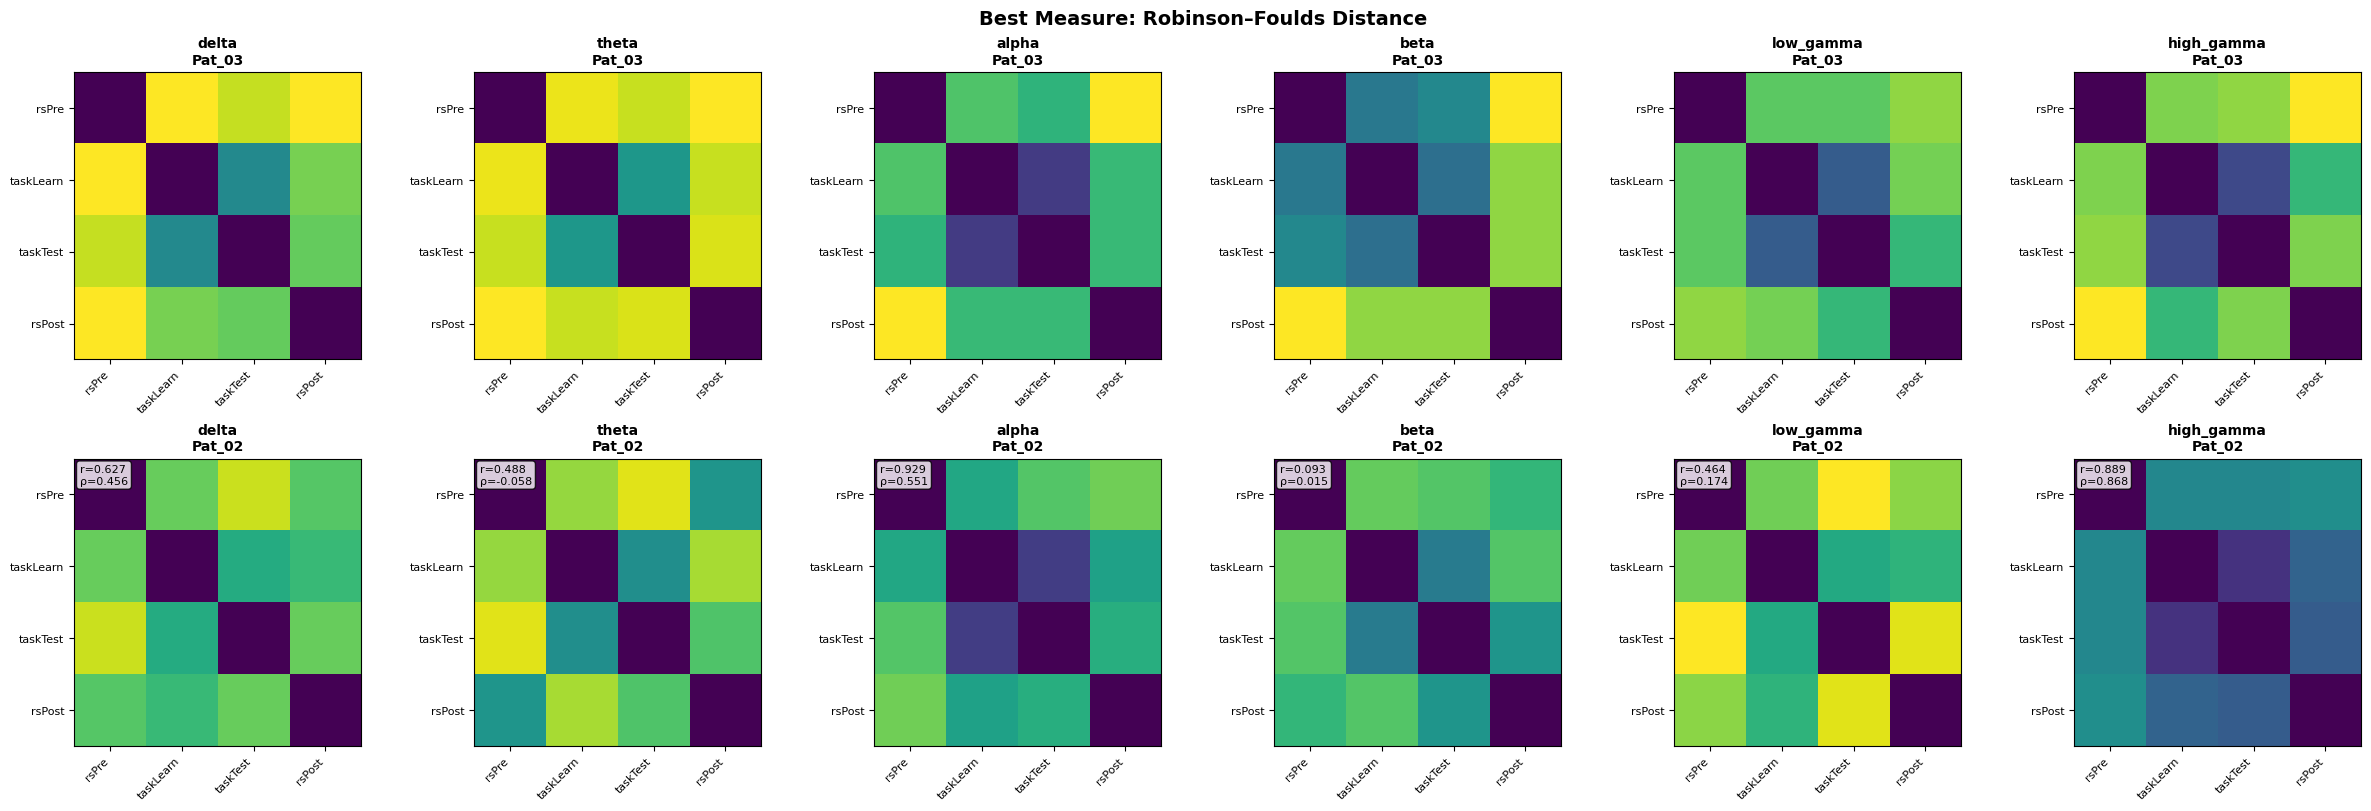

Saved: data/figures/DSTCMP_all_distance_measures/best_measure_tree_robinson_foulds_comparison.png


In [14]:
# Side-by-side comparison of the best measure across patients
best_measure_key = sorted_measures[0][0]
best_measure_label = plot_specs[best_measure_key]['label']

print(f"\n{'='*80}")
print(f"DETAILED VIEW: {best_measure_label}")
print(f"{'='*80}\n")

fig, axes = plt.subplots(2, len(bands), figsize=(4*len(bands), 8), constrained_layout=True)

for j, band in enumerate(bands):
    # Patient 1
    ax = axes[0, j]
    M1 = measure_results[best_measure_key][band][patients[0]]
    vmax = np.nanmax([np.nanmax(M1), np.nanmax(measure_results[best_measure_key][band][patients[1]])])
    
    im = ax.imshow(M1, vmin=0, vmax=vmax, cmap='viridis', aspect='equal')
    ax.set_title(f'{band}\n{patients[0]}', fontsize=10, fontweight='bold')
    ax.set_xticks(range(n_phases))
    ax.set_yticks(range(n_phases))
    ax.set_xticklabels(phase_labels, rotation=45, ha='right', fontsize=8)
    ax.set_yticklabels(phase_labels, fontsize=8)
    
    # Patient 2
    ax = axes[1, j]
    M2 = measure_results[best_measure_key][band][patients[1]]
    
    im = ax.imshow(M2, vmin=0, vmax=vmax, cmap='viridis', aspect='equal')
    ax.set_title(f'{band}\n{patients[1]}', fontsize=10, fontweight='bold')
    ax.set_xticks(range(n_phases))
    ax.set_yticks(range(n_phases))
    ax.set_xticklabels(phase_labels, rotation=45, ha='right', fontsize=8)
    ax.set_yticklabels(phase_labels, fontsize=8)
    
    # Add correlation info
    corr_p = consistency_results[best_measure_key]['pearson'][band]
    corr_s = consistency_results[best_measure_key]['spearman'][band]
    ax.text(0.02, 0.98, f'r={corr_p:.3f}\nρ={corr_s:.3f}', 
            transform=ax.transAxes, fontsize=8, va='top',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

fig.suptitle(f'Best Measure: {best_measure_label}', fontsize=14, fontweight='bold')

outfile = path_figs / f'best_measure_{best_measure_key}_comparison.png'
fig.savefig(outfile, dpi=200, bbox_inches='tight')
plt.show()
print(f'Saved: {outfile}')